# Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import warnings
import math
warnings.filterwarnings('ignore')

In [2]:
fuel1 = pd.read_csv('https://www.dropbox.com/s/ekhha7xfiayrwvq/Fuel_Level_Part_1.csv?raw=1')
fuel2 = pd.read_csv('https://www.dropbox.com/s/lx8g7a8nfvha2jm/Fuel_Level_Part_2.csv?raw=1')
invoices = pd.read_csv('https://www.dropbox.com/s/3vll0ktznaqfa05/Invoices.csv?raw=1')
locations = pd.read_csv('https://www.dropbox.com/s/abtl5gju0i88ik8/Locations.csv?raw=1')
tanks = pd.read_csv('https://www.dropbox.com/s/0kthpvf5d08nozj/Tanks.csv?raw=1')

In [3]:
pd.set_option('display.max_rows', 1000)

# 0. Data overview

## 1) Check time horizon

In [4]:
fuel1['Time stamp'] = pd.to_datetime(fuel1['Time stamp'])


In [5]:
fuel1['Time stamp'].dt.year

0         2017
1         2017
2         2017
3         2017
4         2017
          ... 
885146    2019
885147    2019
885148    2019
885149    2019
885150    2019
Name: Time stamp, Length: 885151, dtype: int64

## 2) Inventory Overview

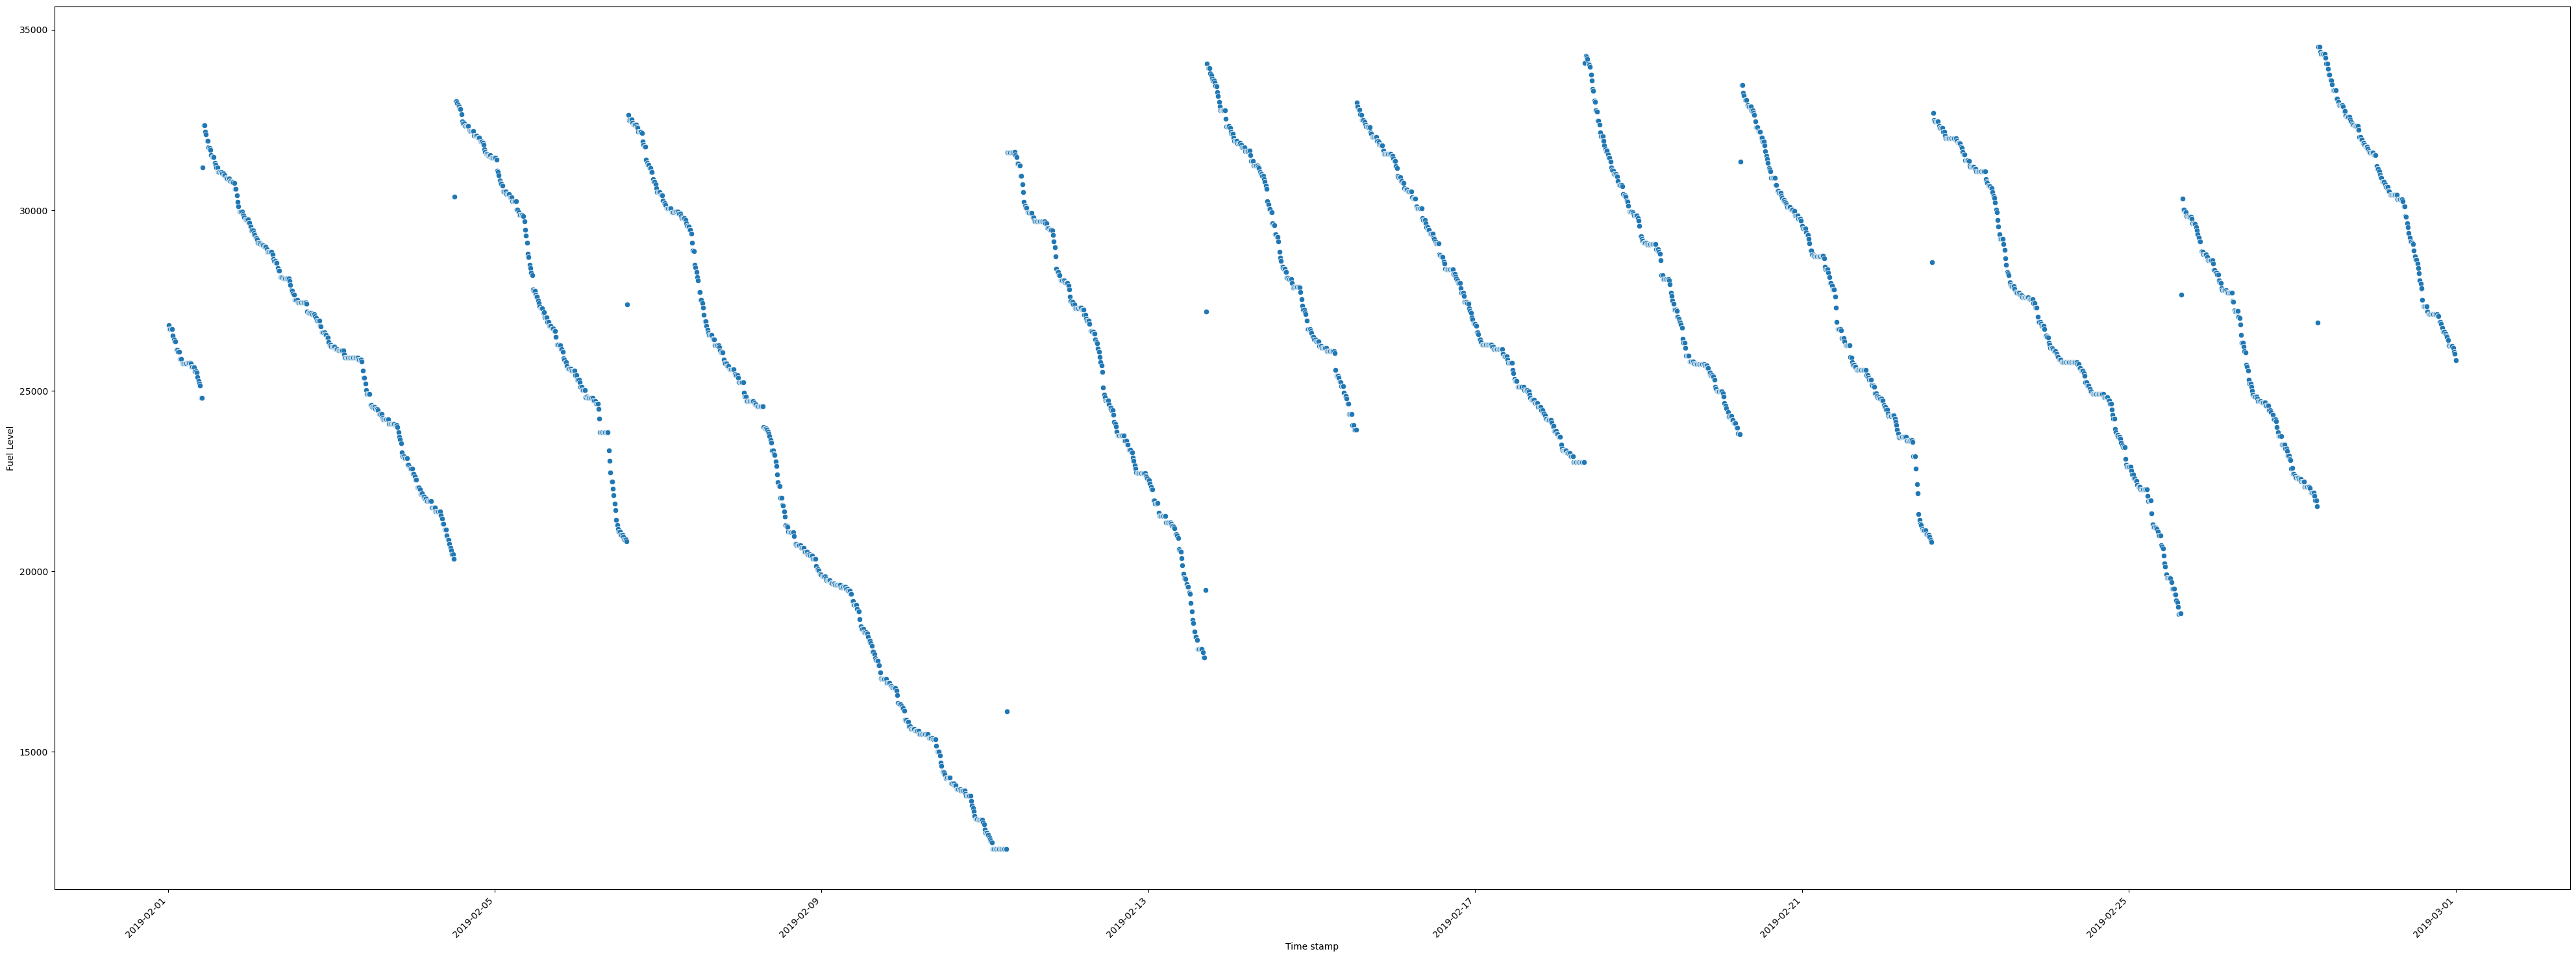

In [6]:
tank1 = fuel1[fuel1['Tank ID'].eq('T 12')].loc[ fuel1['Time stamp'].dt.year==2019
                                       , ['Time stamp', 'Fuel Level']]

tank1_feb = tank1.loc[tank1['Time stamp'].dt.month.eq(2)]

fig, ax = plt.subplots(figsize=(50, 20))
sns.scatterplot(data=tank1_feb, x="Time stamp", y="Fuel Level", ax=ax)

fig.autofmt_xdate(rotation=45)
# plt.figure(figsize=(24, 18), dpi=300)
plt.savefig('saving-a-high-resolution-seaborn-plot.png', dpi=300)

# 1. Data Cleansing and Transformation

## 1) Cleaning Fuel Level

In [7]:
# change T12 to T 12, then everything is ok.
fuel1['Tank ID'] = fuel1['Tank ID'].replace({'T12': 'T 12'})
fuel1['Tank ID'].unique()


array(['T 12', 'T 13', 'T 15', 'T 17', 'T 19', 'T 21', 'T 23', 'T 24',
       'T 28', 'T 30', 'T 31'], dtype=object)

In [8]:
# standardizing fuel table column names
fuel2_renamed = fuel2.rename({'Fuel_Level': 'Fuel Level', 'Timestamp': 'Time stamp'}, axis=1)  # new method


In [9]:
# merge both fuel dataframes into one
fuel = pd.concat([fuel1, 
                  fuel2_renamed]).drop_duplicates().reset_index(drop='True')


In [10]:
# join with tank metainfo
fuel_with_meta = fuel.merge(tanks,
                            how = 'outer',
                            on = 'Tank ID',
                            validate='m:1')


In [11]:
# gas station location 8, index 7, Chappel, has incorrect long,lat, so we update it.
new_lat = pd.Series([43.198460], name='Gas Station Latitude', index=[7])
new_long = pd.Series([-79.864630], name='Gas Station Longitude', index=[7])
locations.update(new_lat)
locations.update(new_long)


In [12]:
# join location ID with gas station information

fuel_with_station = fuel_with_meta.merge(locations, 
                                         how = 'outer',
                                         left_on = 'Tank Location',
                                         right_on = 'Gas Station Location',
                                         validate='m:1'
                                        )



In [13]:
# Dropping 'P' from tank types
fuel_with_station = fuel_with_station[fuel_with_station['Tank Type'].ne('P')]


In [14]:
# Null value analysis
display(fuel_with_station.columns)
fuel_with_station.dropna(how='any', inplace=True)   # checked, only drops two entries


Index(['Tank ID', 'Fuel Level', 'Time stamp', 'Tank Location', 'Tank Number',
       'Tank Type', 'Tank Capacity', 'Gas Station Location',
       'Gas Station Name', 'Gas Station Address', 'Gas Station Latitude',
       'Gas Station Longitude'],
      dtype='object')

In [15]:
%%time
# changing "Time stamp" dtype to datatime for both
fuel_with_station['Time stamp'] = pd.to_datetime(fuel_with_station['Time stamp'])  # slow to run


CPU times: user 1min 14s, sys: 446 ms, total: 1min 14s
Wall time: 1min 17s


In [16]:
# check duplicates
fuel_with_station.duplicated().sum() 
# no duplicates

0

In [17]:
# group by test, not working that well
fuel_with_station.groupby(by=['Gas Station Name', 'Tank Type', 'Time stamp'])\
                            ['Fuel Level'].min()

Gas Station Name  Tank Type  Time stamp         
Central           D          2017-01-01 00:07:00    14450.0
                             2017-01-01 00:22:00    14450.0
                             2017-01-01 00:37:00    14450.0
                             2017-01-01 00:52:00    14450.0
                             2017-01-01 01:07:00    14450.0
                                                     ...   
Oakville          U          2019-08-15 23:06:00    17122.0
                             2019-08-15 23:21:00    17122.0
                             2019-08-15 23:36:00    17122.0
                             2019-08-15 23:50:00    19030.0
                             2019-08-15 23:51:00    17122.0
Name: Fuel Level, Length: 1458275, dtype: float64

## 2) Cleaning Invoices

In [18]:
invoices['Invoice Gas Station Location'].value_counts()

1     1368
2      638
4      363
5      287
3       85
7       52
6       44
8       31
20       1
17       1
21       1
41       1
11       1
Name: Invoice Gas Station Location, dtype: int64

In [19]:
# remove locations that don't exists [20, 17, 21, 41, 11] 
invoices = invoices[invoices['Invoice Gas Station Location'].isin(locations['Gas Station Location'])]

In [20]:
# merge location with invoices
purchase_per_location = locations.merge(invoices, 
                                         how = 'inner',
                                         left_on = 'Gas Station Location',
                                         right_on = 'Invoice Gas Station Location',
                                         validate='1:m'
                                        )

In [21]:
# drop null value rows
purchase_per_location = purchase_per_location.dropna(how='any')

# change to datetime types
purchase_per_location['Invoice Date'] = pd.to_datetime(purchase_per_location['Invoice Date'])

# change G to U to standarize Fuel Type notation
purchase_per_location['Fuel Type'] = purchase_per_location['Fuel Type'].replace(to_replace={'G': 'U'})



## 3)Cleaning Tanks

In [22]:
tanks['Tank Type'].replace(to_replace={'G':'U'})
tanks = tanks[tanks['Tank Type'] != 'P']

In [23]:
table = pd.pivot_table(tanks, values='Tank ID', index=['Tank Location','Tank Type'],
               aggfunc='count').reset_index()
table.rename(columns = {'Tank ID':'Tank Number'},inplace = True)
table

Tank Location Tank Type  Tank Number
0               1         D            2
1               1         U            3
2               2         D            2
3               2         U            2
4               3         D            1
5               3         U            1
6               4         D            1
7               4         U            1
8               5         D            1
9               5         U            1
10              6         D            1
11              6         U            2
12              7         D            1
13              7         U            1
14              8         D            1
15              8         U            1

# 2. Inventory and Order Purchasing Analysis

## 1) Inventory Per Station Per Fuel Type (by Day and Month)

In [24]:
station_inventory = fuel_with_station[['Gas Station Name', 'Tank Type', 'Time stamp', 'Fuel Level']].sort_values(by=['Gas Station Name', 'Time stamp'])

In [25]:
station_inventory.groupby(by=['Gas Station Name', 'Tank Type', station_inventory['Time stamp'].dt.month])['Fuel Level'].sum();


In [26]:
station_by_month = station_inventory.groupby(by=['Gas Station Name', 'Tank Type', station_inventory['Time stamp']\
                              .dt.to_period('M')])['Fuel Level'].mean()

station_by_day = station_inventory.groupby(by=['Gas Station Name', 'Tank Type', station_inventory['Time stamp']\
                              .dt.to_period('D')])['Fuel Level'].mean()


In [27]:
# extract station names and gas types
station_names = set()
gas_types = set()

for index in station_by_day.index:
  station_names.add(index[0])
  gas_types.add(index[1])

station_names = sorted((station_names))
gas_types = sorted(gas_types)


In [28]:
# NOTE: CUSTOM FUNCTION(For Inventory's Line Plot)
# To plot 8x2 graphs, based on df and column names

def plot_per_station_per_fuel(df, xname, yname, desc):
  """
  function that return a 8(stations)*2(fuel types) line plot of wanted x and y.
  """
  fig, axs = plt.subplots(8, 2)
  for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
      # filter df
      df_filtered = df[df['Gas Station Name'].eq(station_names[i]) \
                                                & df['Tank Type'].eq(gas_types[j])]
      # extract x and y
      try:
        x = df_filtered[xname].dt.to_timestamp()
      except Exception:
        x = df_filtered[xname]
        
      y = df_filtered[yname]

      # plot
      axs[i, j].plot(x, y)
      axs[i, j].set_title(f'{station_names[i]} ({gas_types[j]})')
      axs[i, j].set_xlabel(xname)
      axs[i, j].set_ylabel(yname) 

      # formatting 
      plt.subplots_adjust(wspace=.5)
      plt.subplots_adjust(hspace=.5)
      fig.set_size_inches(30, 30)
        
  fig.suptitle(f'{desc} by Station and Fuel Type')


In [29]:
# pop them back into column for easy query
df_station_by_month = station_by_month.reset_index()
df_station_by_day = station_by_day.reset_index()


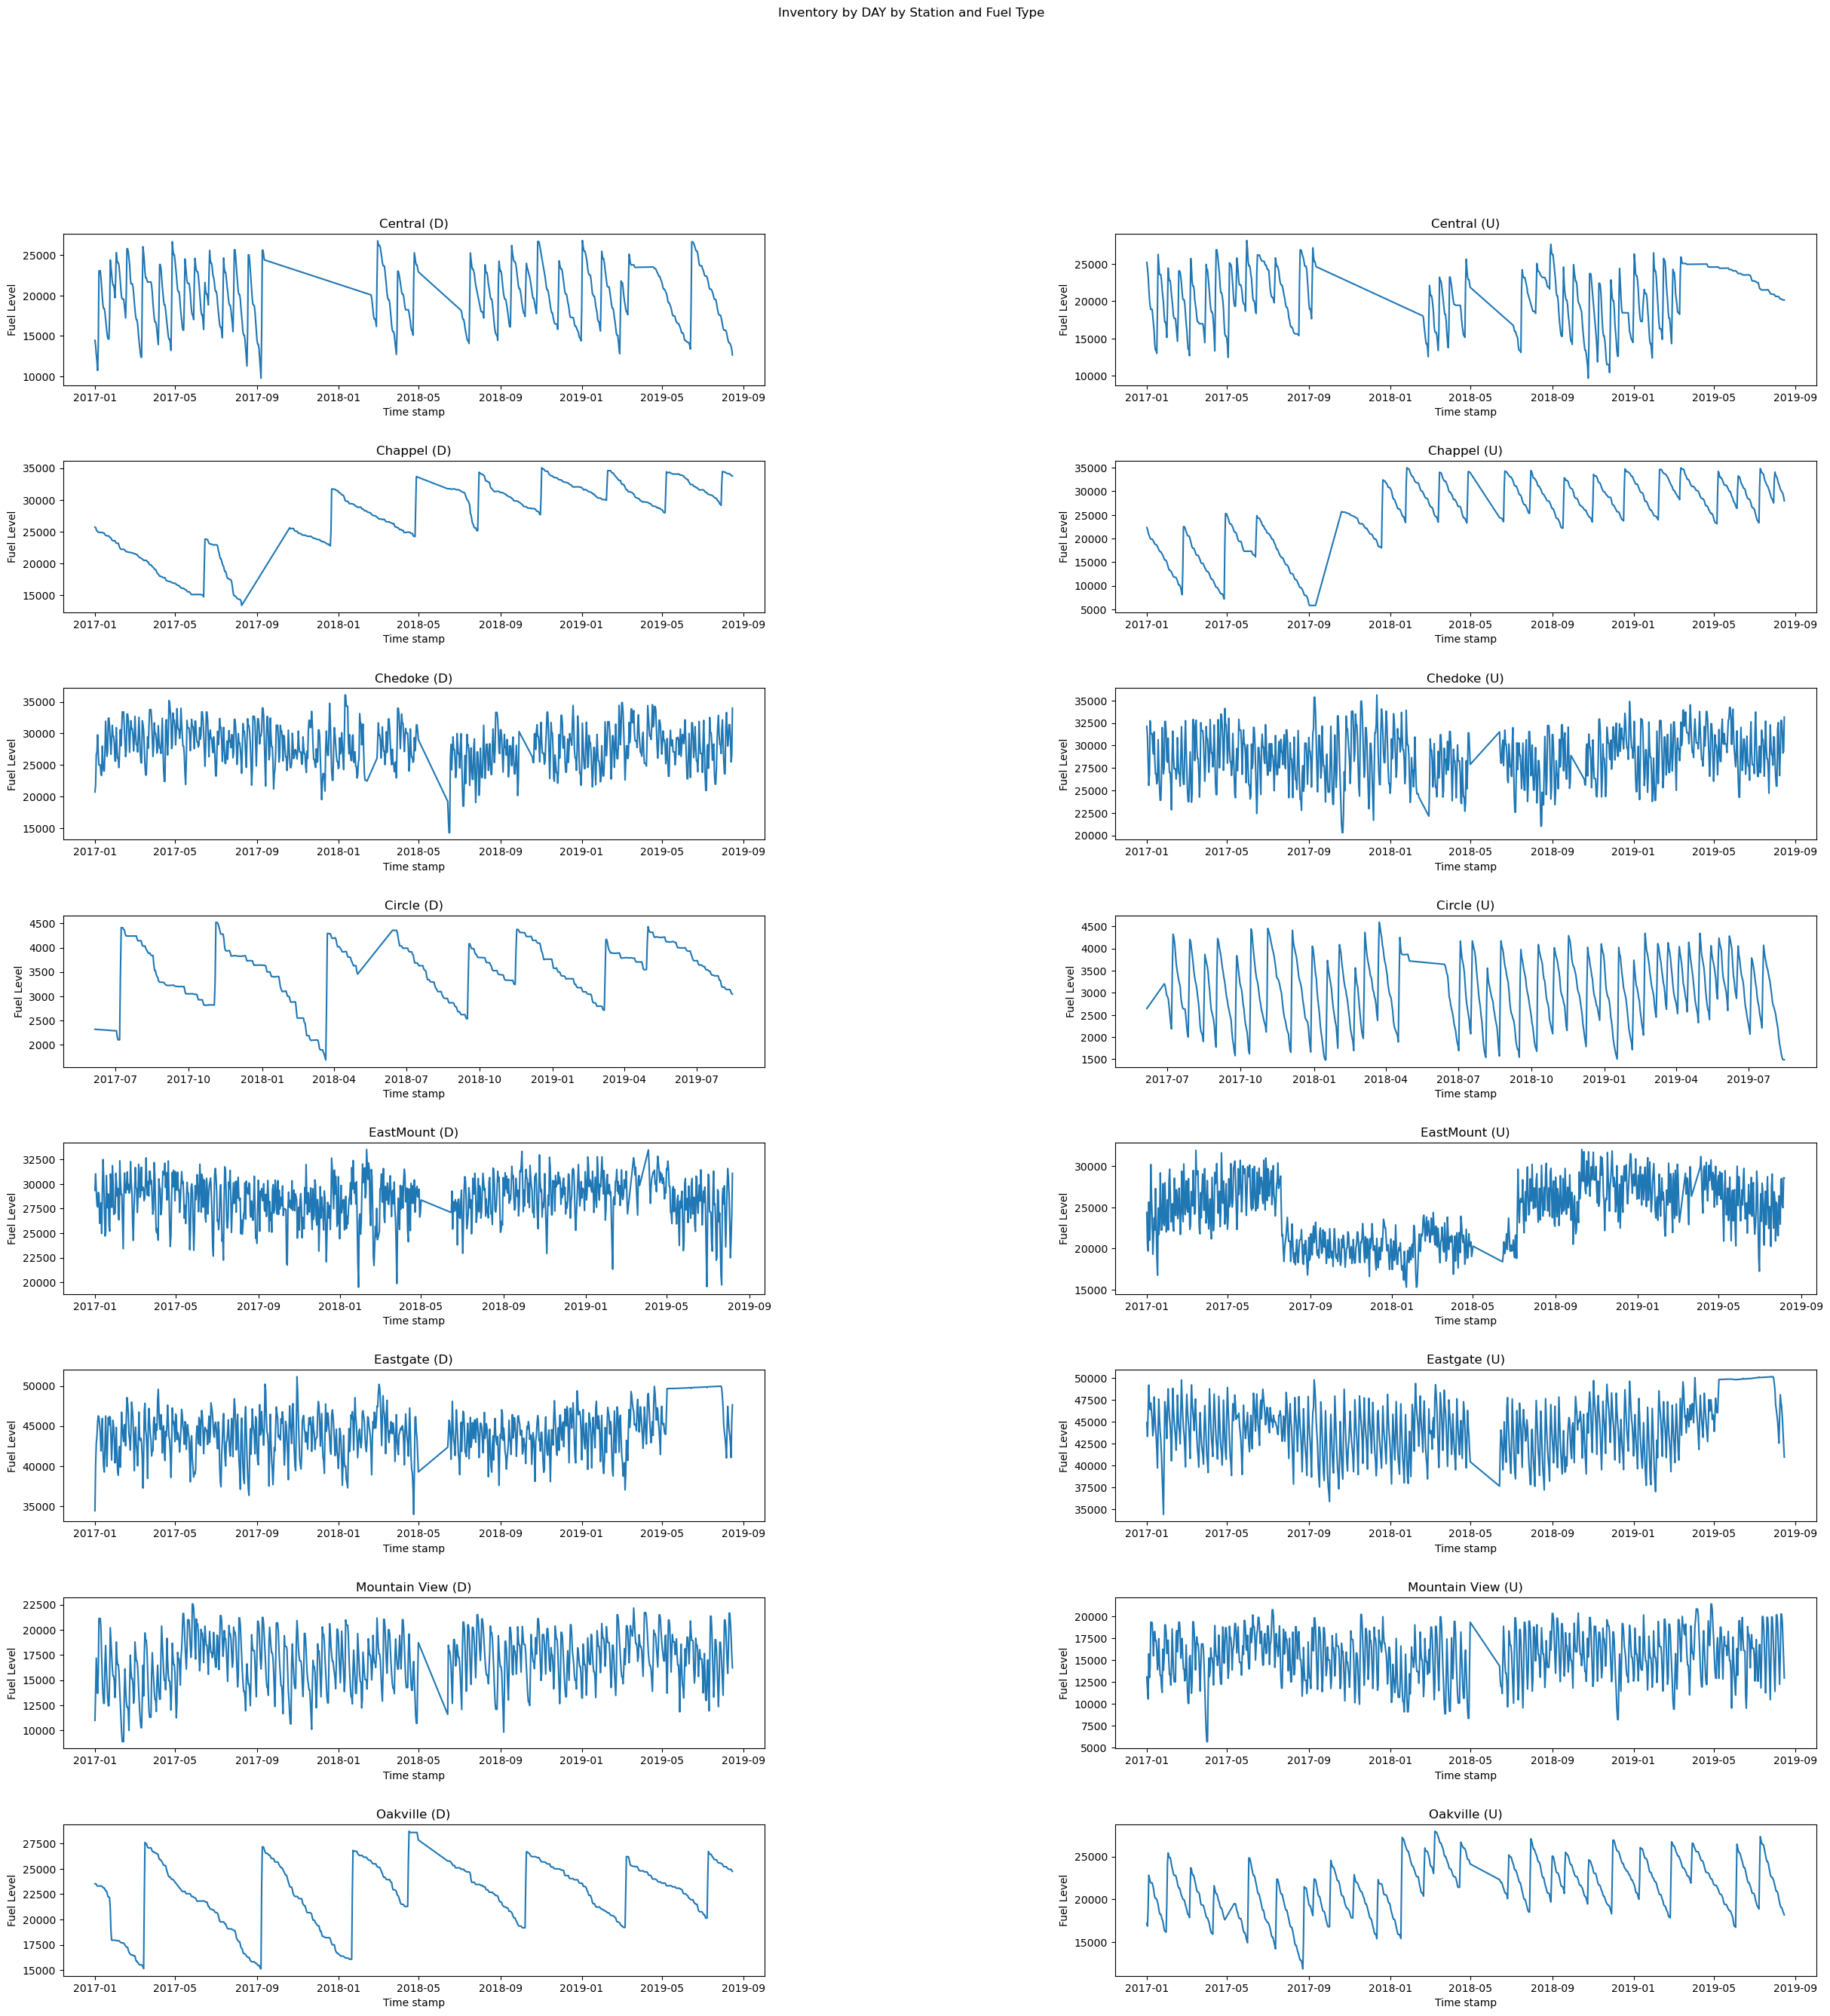

In [30]:
# daily visualization
plot_per_station_per_fuel(df = df_station_by_day,
                          xname = "Time stamp",
                          yname = "Fuel Level",
                          desc = "Inventory by DAY")

 

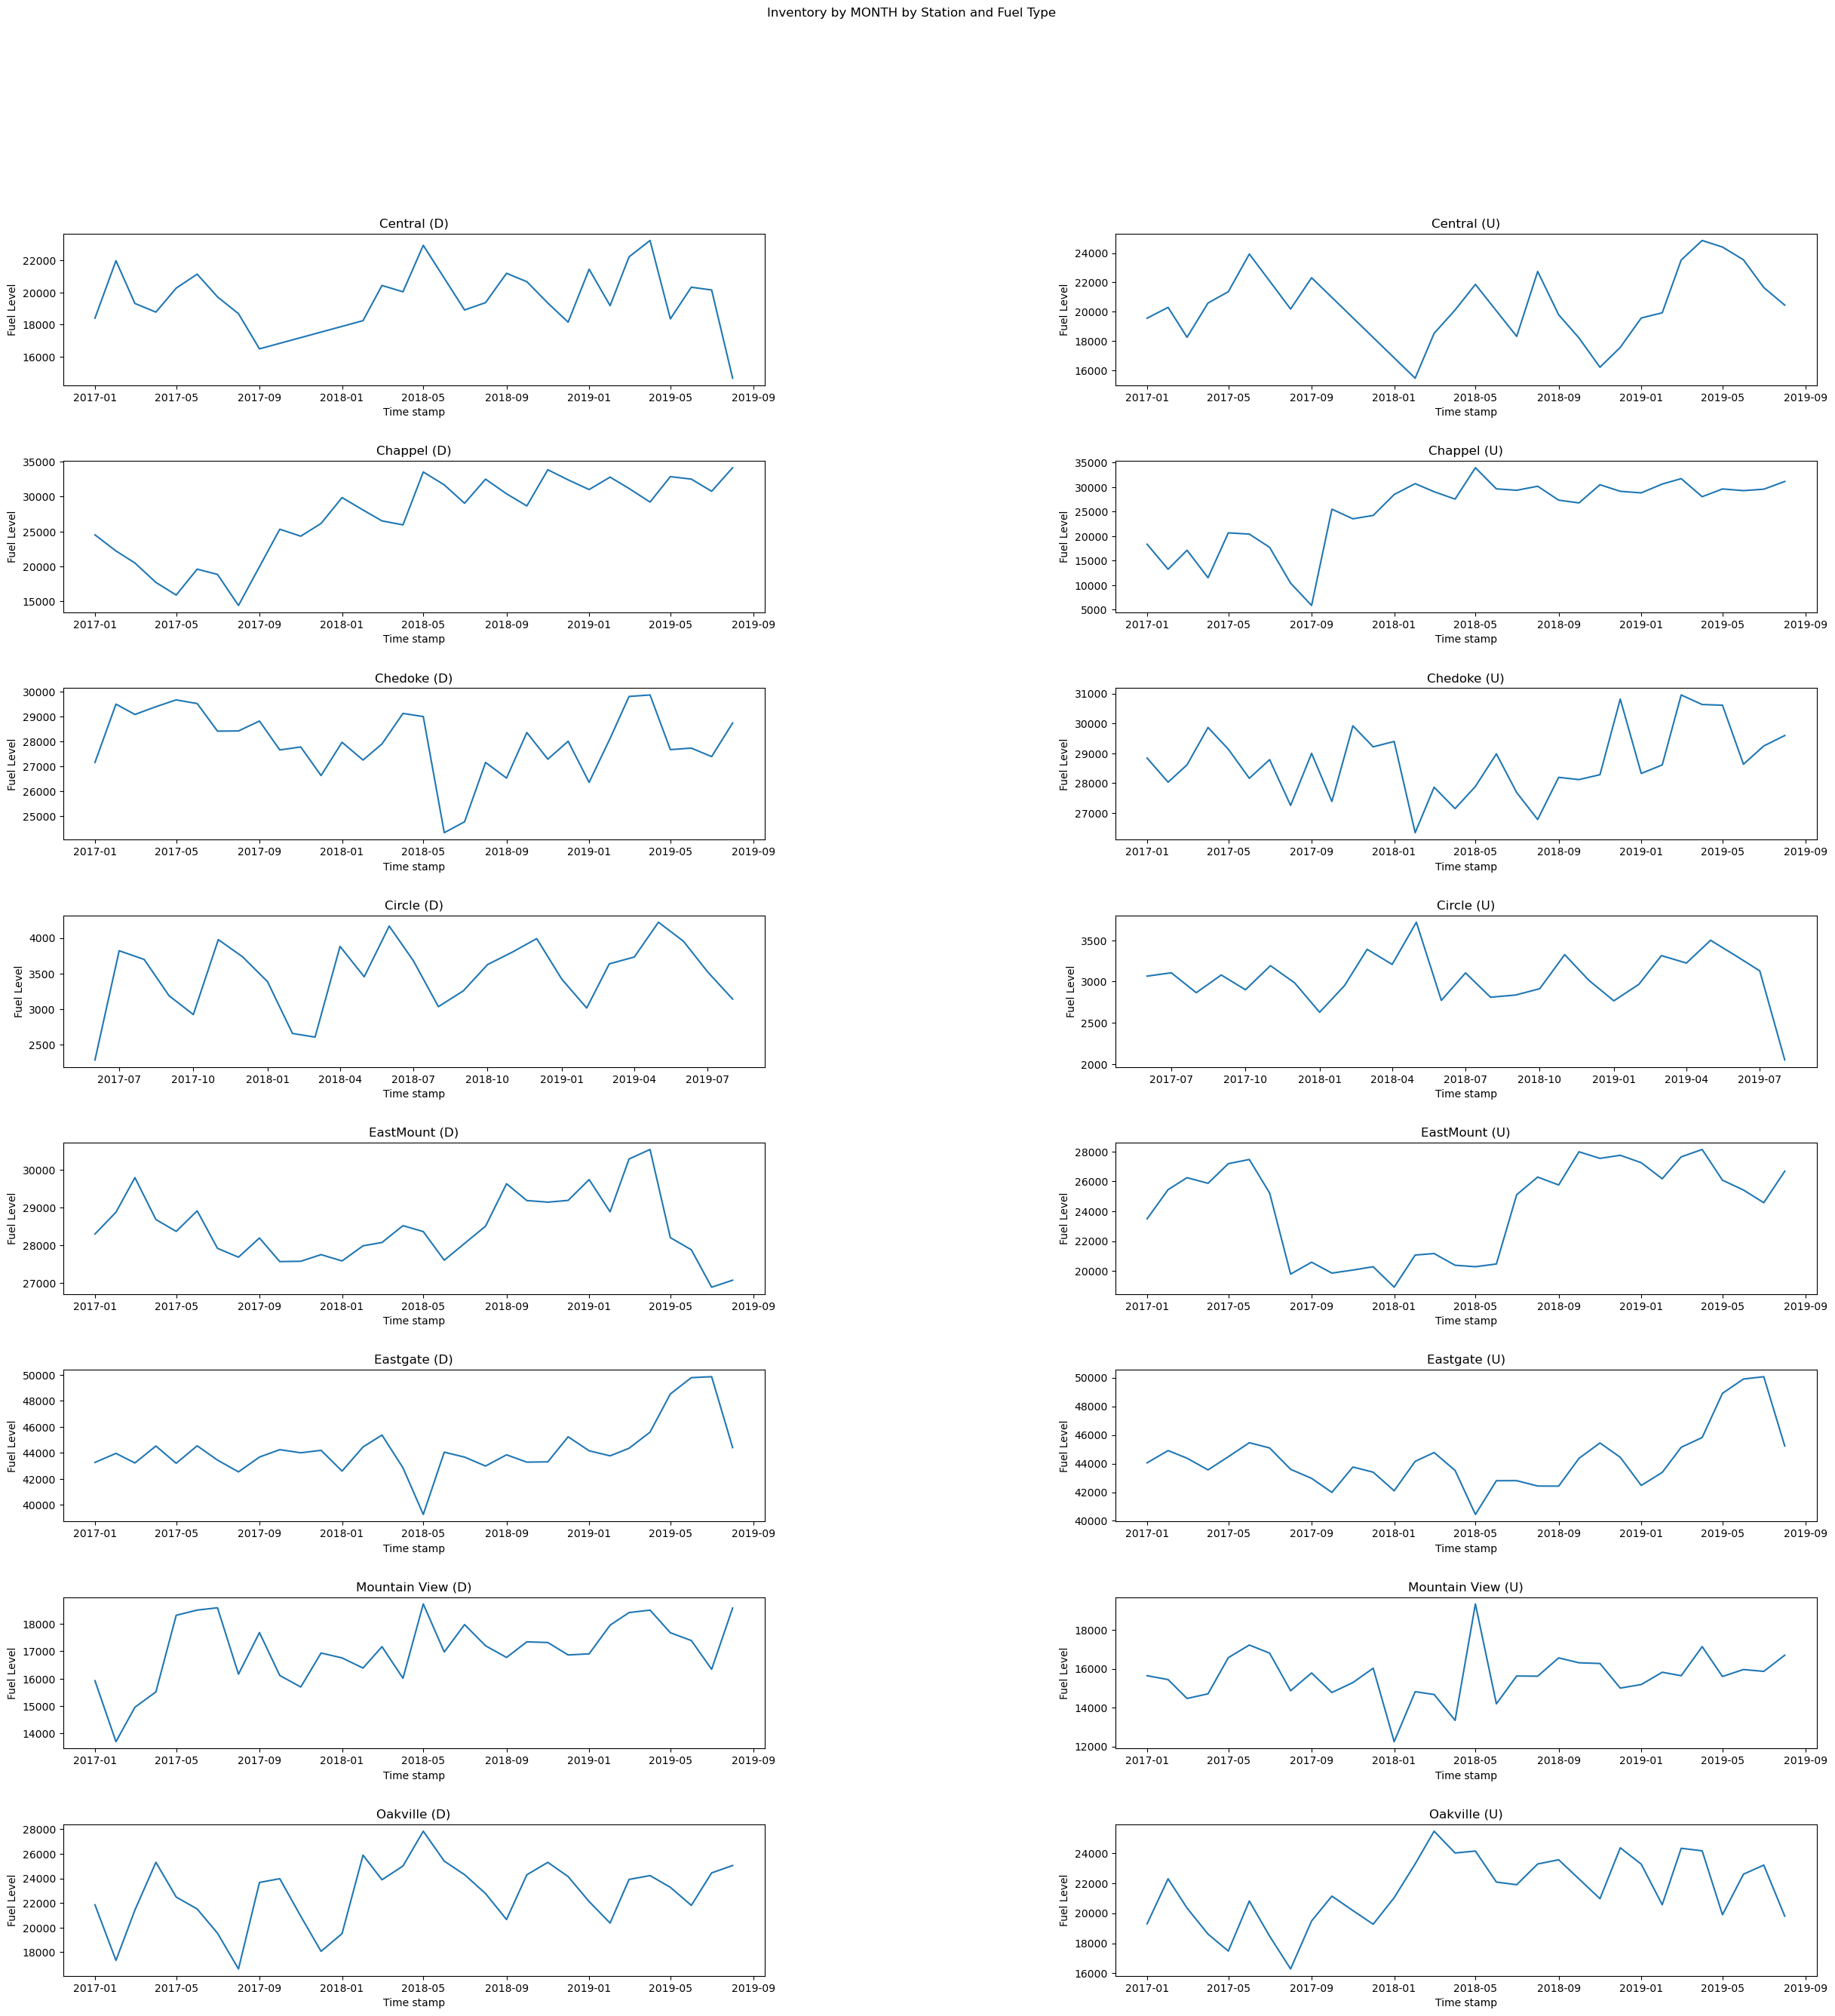

In [31]:
# monthly visualization
plot_per_station_per_fuel(df = df_station_by_month,
                          xname = "Time stamp",
                          yname = "Fuel Level",
                          desc = "Inventory by MONTH")


## 2) Purchasing amount per station per fuel type 

In [32]:
# NOTE: CUSTOM FUNCTION(For Purchasing Order's Scatter Plot)
# To plot 8x2 graphs, based on df and column names

def plot_per_station_per_fuel_scatter(df, xname, yname, desc):
  """
  function that return a 8(stations)*2(fuel types) scatter plot of wanted x and y.
  """
  fig, axs = plt.subplots(8, 2)
  for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
      # filter df
      df_filtered = df[df['Gas Station Name'].eq(station_names[i]) \
                                                & df['Tank Type'].eq(gas_types[j])]
      # extract x and y
      try:
        x = df_filtered[xname].dt.to_timestamp()
      except Exception:
        x = df_filtered[xname]
        
      y = df_filtered[yname]

      # plot
      axs[i, j].scatter(x, y)
      axs[i, j].set_title(f'{station_names[i]} ({gas_types[j]})')
      axs[i, j].set_xlabel(xname)
      axs[i, j].set_ylabel(yname) 

      # formatting 
      plt.subplots_adjust(wspace=.5)
      plt.subplots_adjust(hspace=.5)
      fig.set_size_inches(30, 30)
        
  fig.suptitle(f'{desc} by Station and Fuel Type')

In [33]:
df_filtered_amounts = purchase_per_location[['Gas Station Name', 'Fuel Type', 'Invoice Date', 'Amount Purchased', 'Gross Purchase Cost']]
df_filtered_amounts.rename({'Fuel Type': 'Tank Type'}, axis=1, inplace=True)


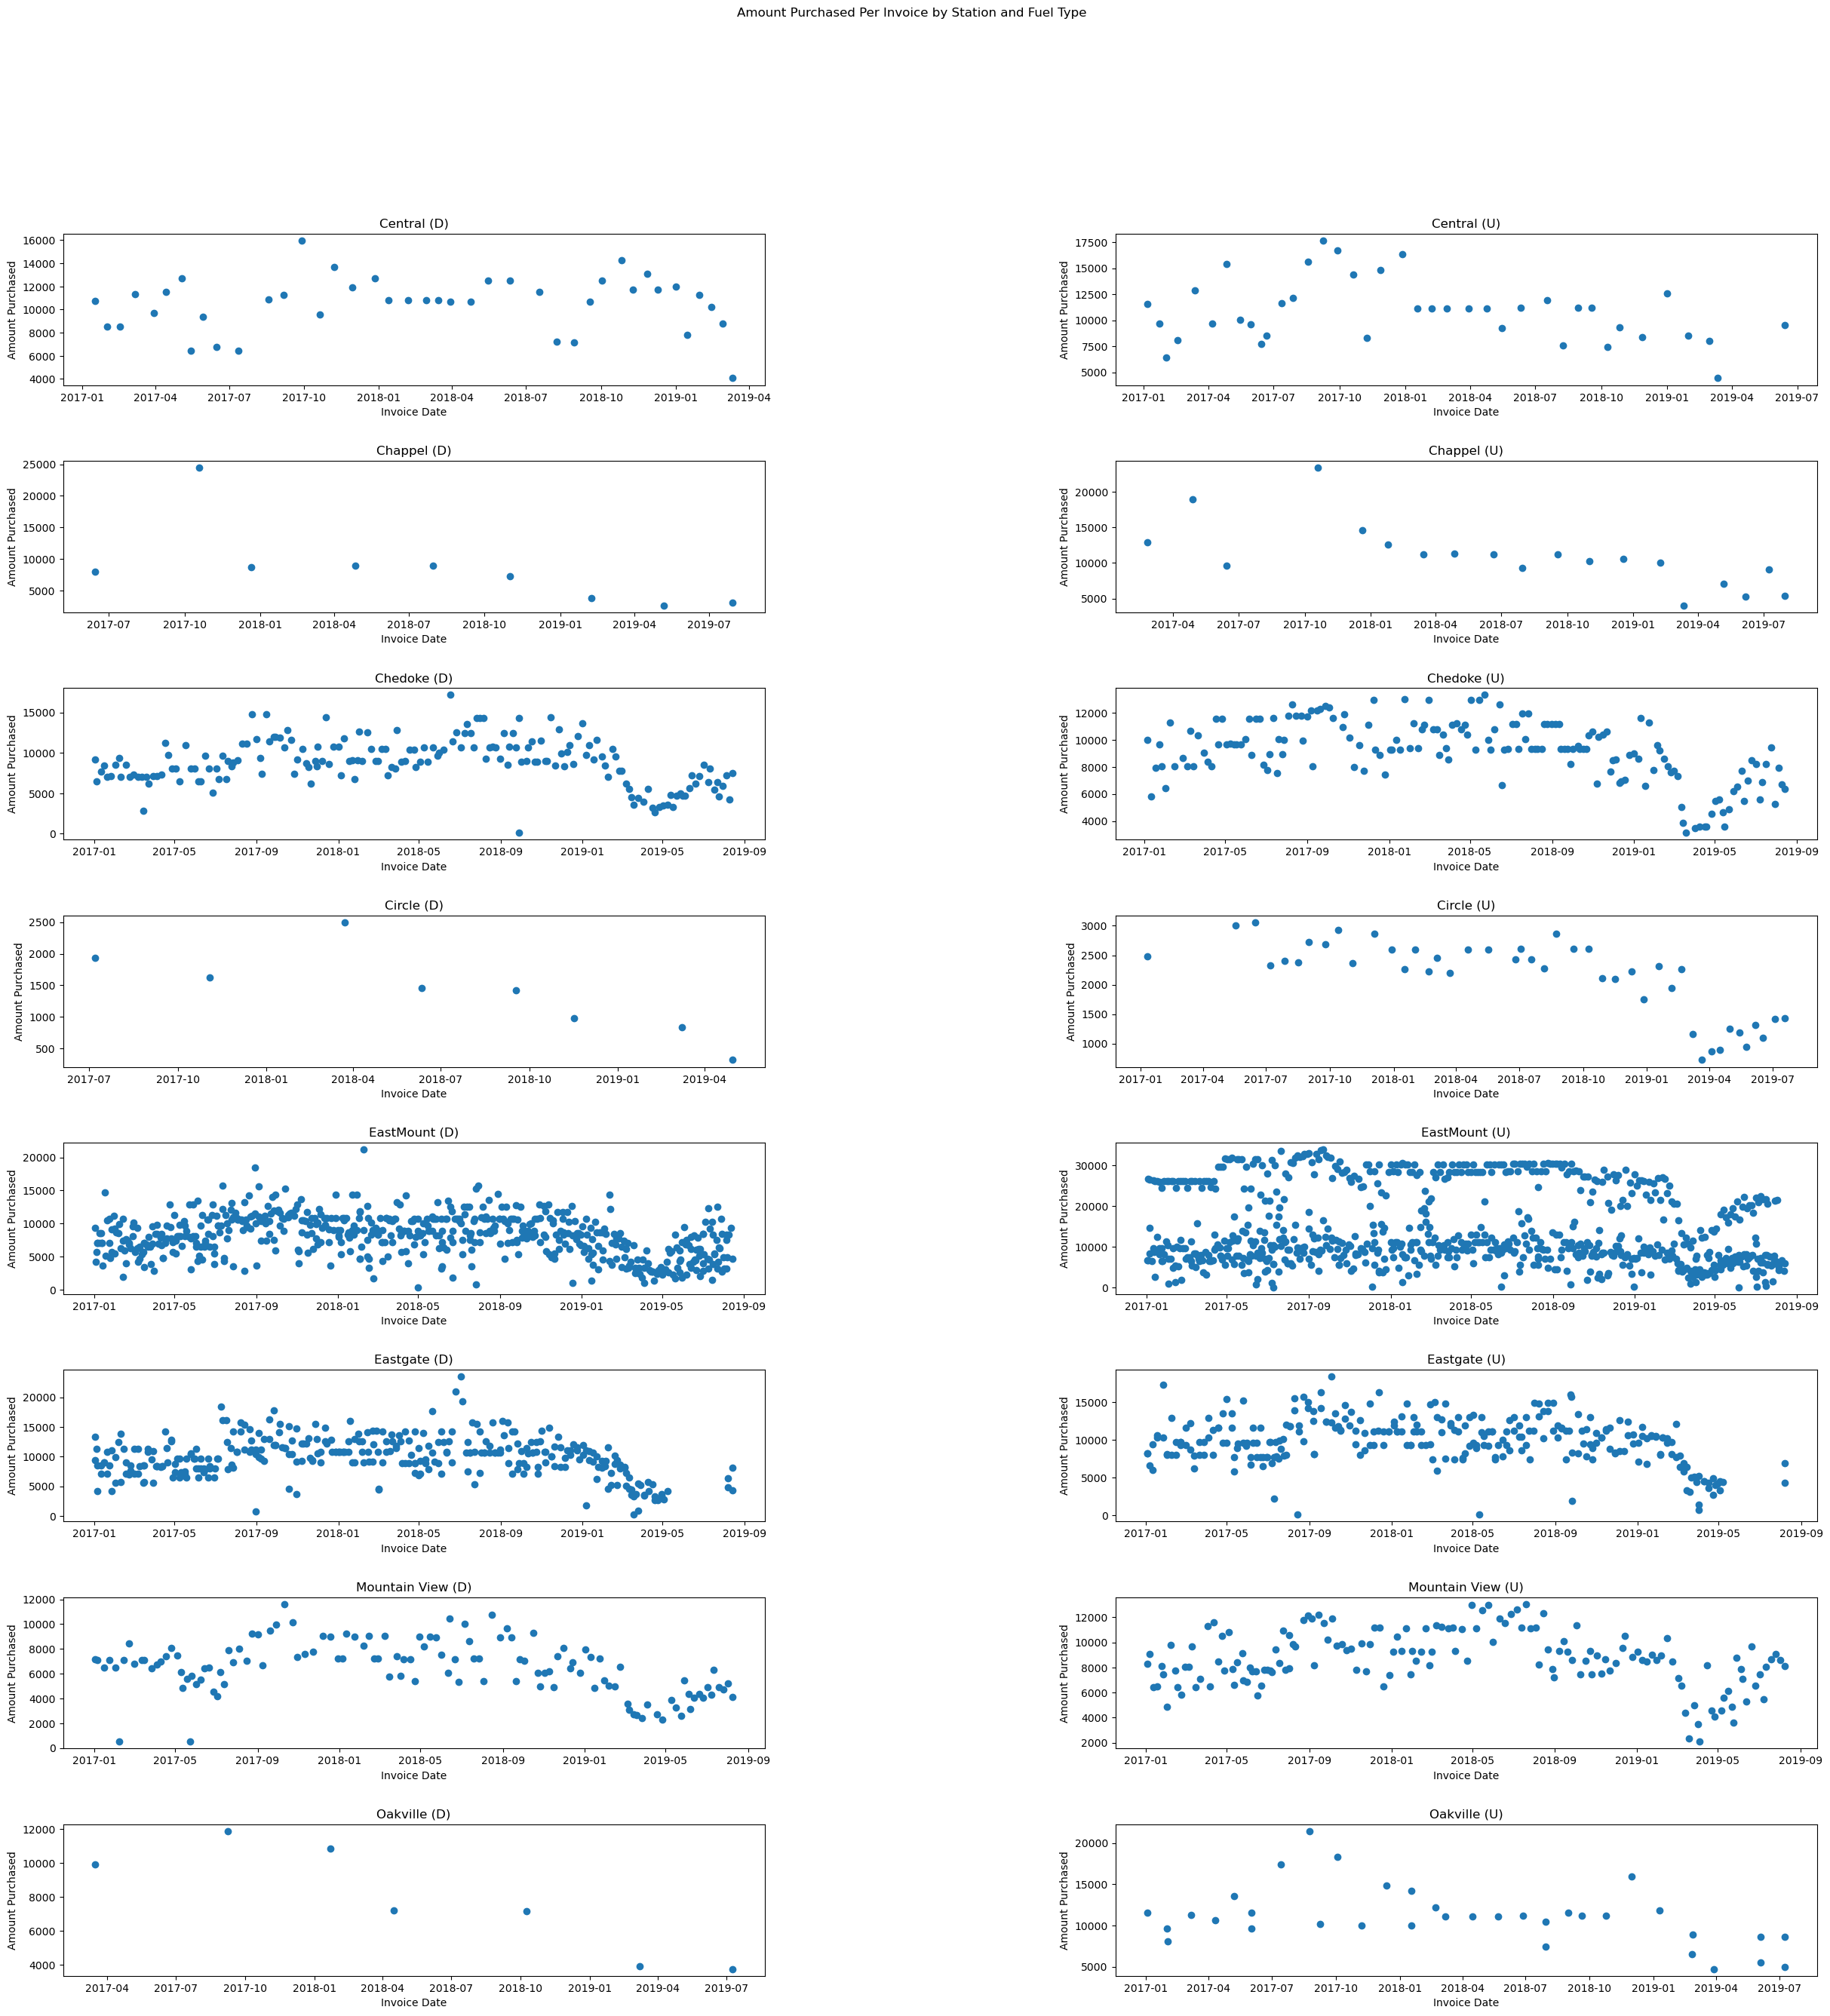

In [34]:
# plots
plot_per_station_per_fuel_scatter(df=df_filtered_amounts,
                          xname='Invoice Date',
                          yname='Amount Purchased',
                          desc="Amount Purchased Per Invoice"
                          )

## 3) Average purchasing price per station per fuel type

In [35]:
df_filtered_amounts.head()

Gas Station Name Tank Type Invoice Date  Amount Purchased  \
0        EastMount         U   2017-01-02          6609.600   
1        EastMount         D   2017-01-02          9338.736   
3        EastMount         D   2017-01-03          4239.216   
4        EastMount         U   2017-01-03          6659.184   
5        EastMount         U   2017-01-03         26704.960   

   Gross Purchase Cost  
0           7570.82000  
1          12491.85300  
3           5670.54418  
4           7627.60115  
5          32175.98500

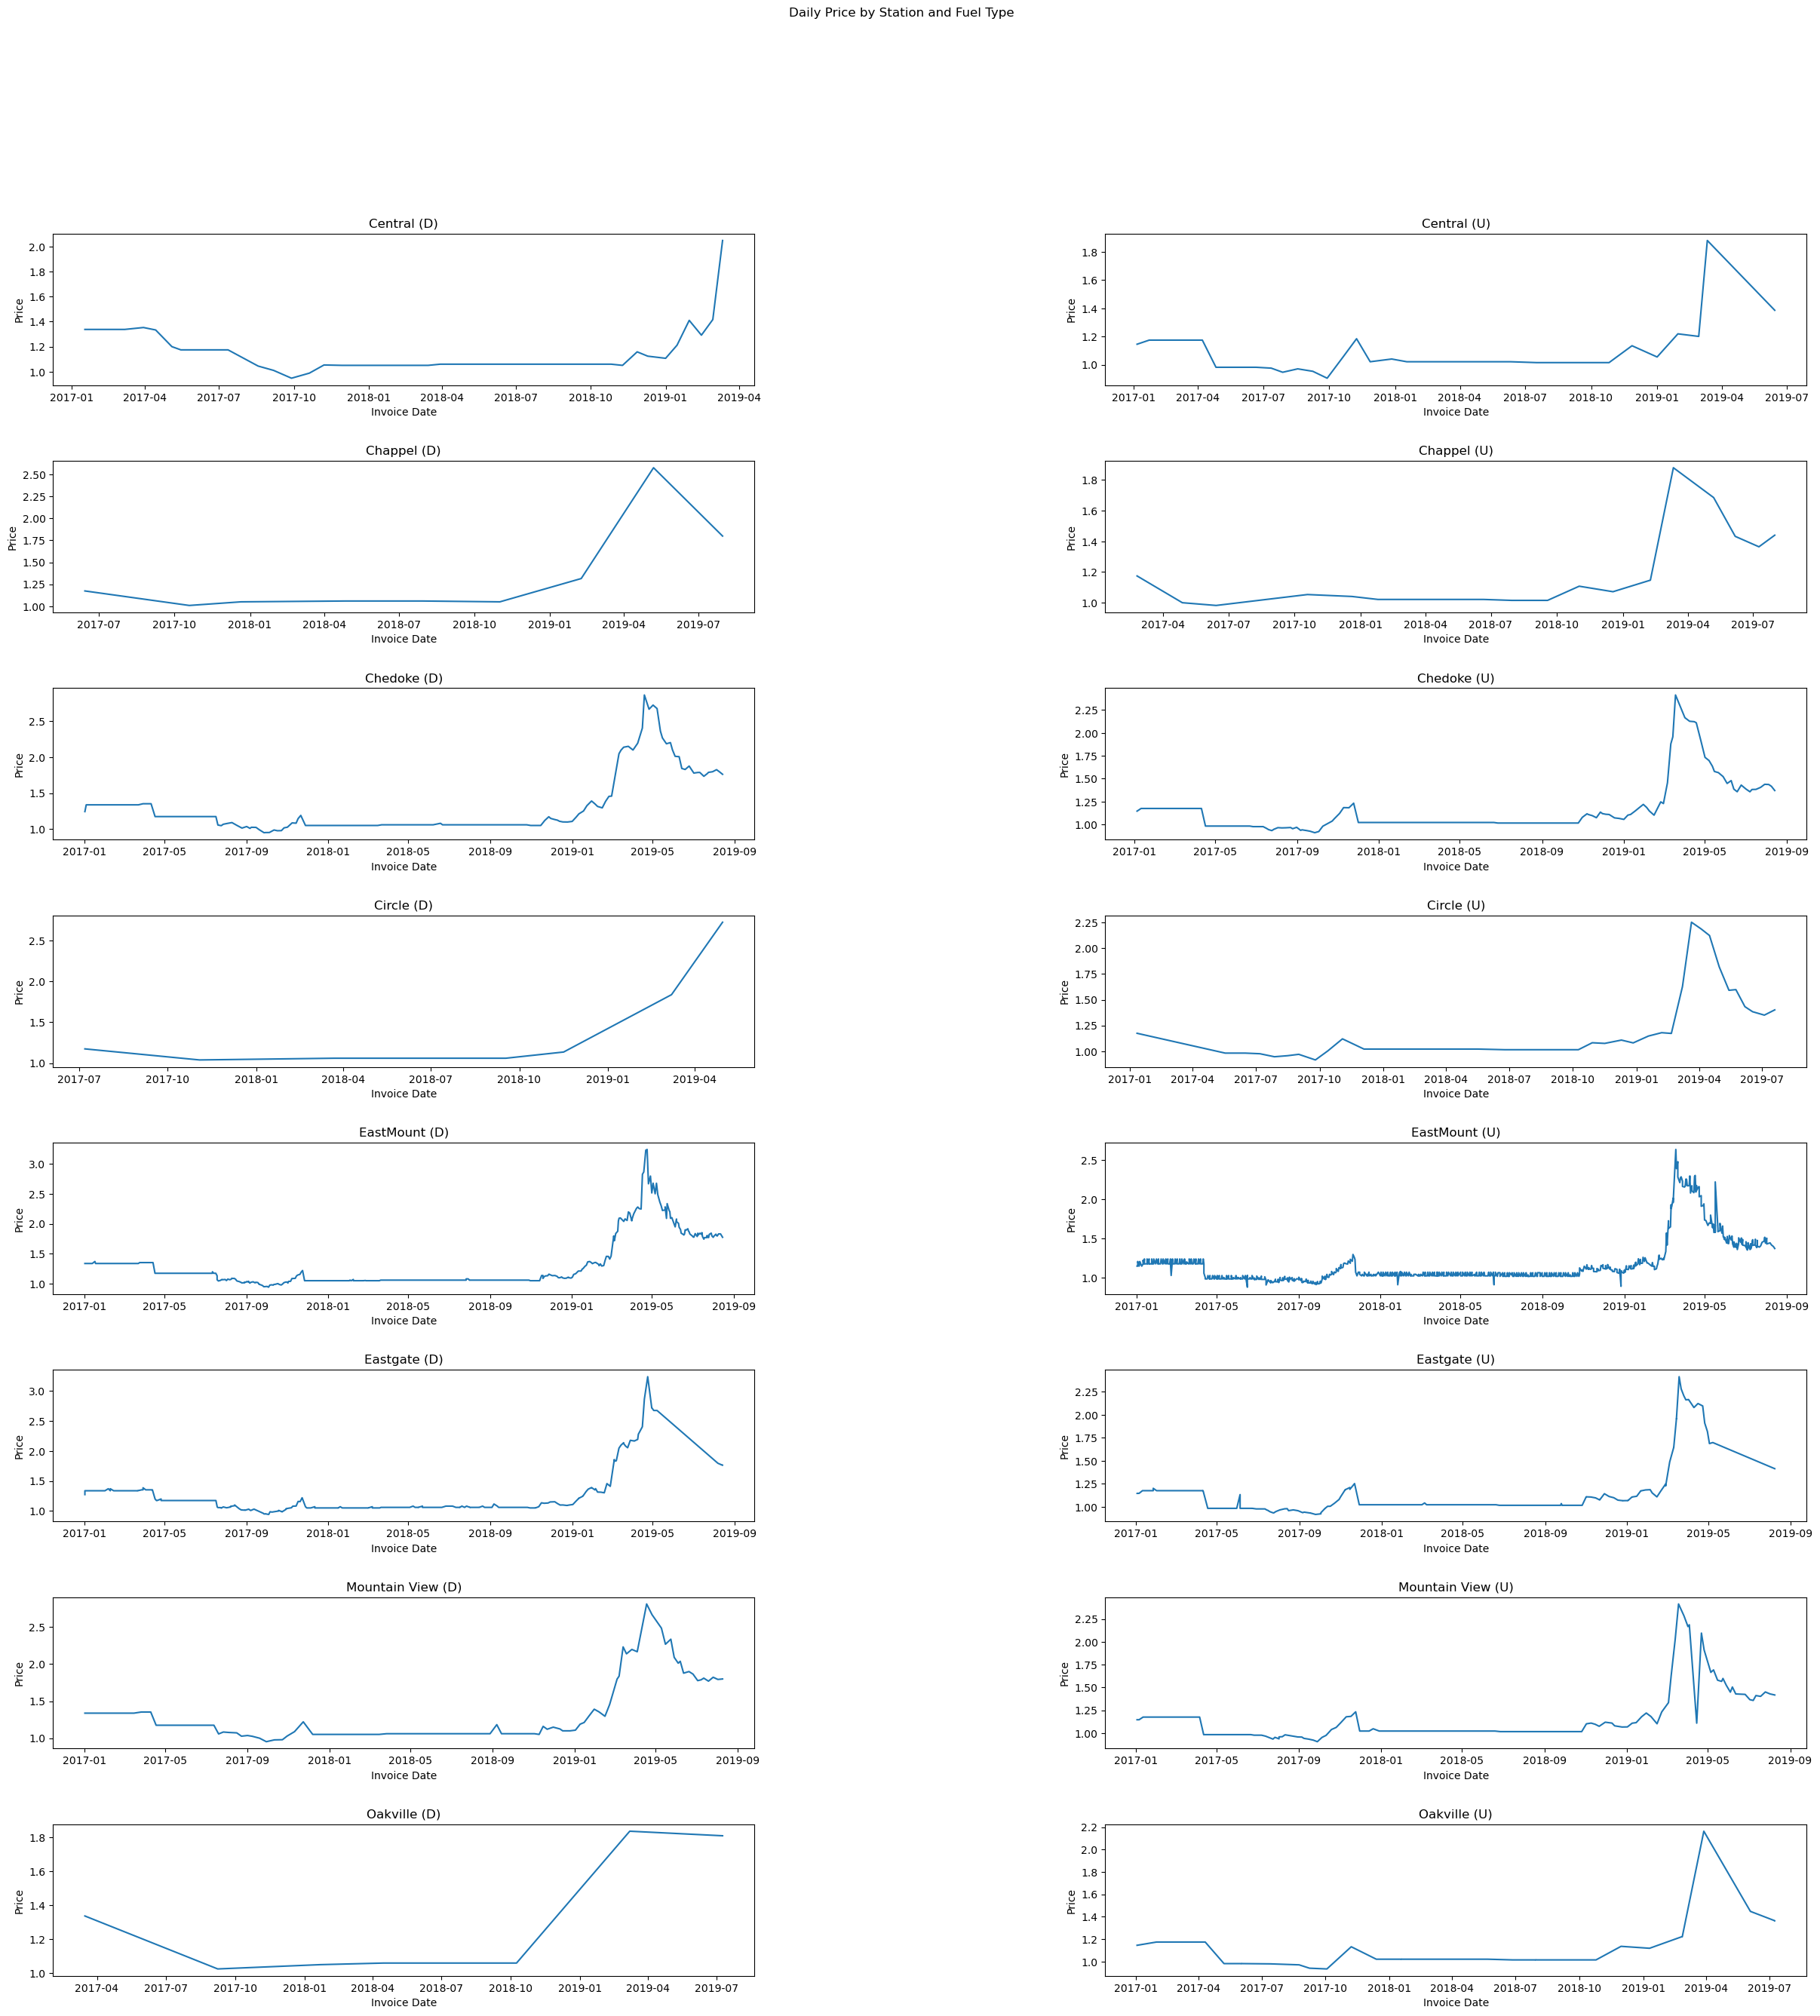

In [36]:
# Plot of daily purchasing price
df_filtered_amounts['Price'] = df_filtered_amounts['Gross Purchase Cost'].div(df_filtered_amounts['Amount Purchased'])
plot_per_station_per_fuel(
    df= df_filtered_amounts,
    xname= 'Invoice Date',
    yname= 'Price',
    desc= 'Daily Price'
)

# 3. Station Specific Inventory Management

## 1) Descriptives of purchasing price per station per fuel type

In [37]:
price_type_u = df_filtered_amounts[df_filtered_amounts['Tank Type']=='U']\
          .groupby(by=df_filtered_amounts['Gas Station Name'])['Price']

display(price_type_u.mean().sort_values())
display(price_type_u.min().sort_values())
display(price_type_u.max().sort_values())

Gas Station Name
Central          1.079401
Eastgate         1.125573
Oakville         1.127866
Chedoke          1.146347
Mountain View    1.150962
EastMount        1.172297
Chappel          1.184023
Circle           1.203315
Name: Price, dtype: float64

Gas Station Name
EastMount        0.876578
Mountain View    0.904664
Central          0.904666
Chedoke          0.909605
Eastgate         0.915765
Circle           0.915771
Oakville         0.934540
Chappel          0.982101
Name: Price, dtype: float64

Gas Station Name
Central          1.880370
Chappel          1.880370
Oakville         2.163388
Circle           2.252372
Mountain View    2.415150
Chedoke          2.415150
Eastgate         2.415151
EastMount        2.635493
Name: Price, dtype: float64

In [38]:
price_type_d = df_filtered_amounts[df_filtered_amounts['Tank Type']=='D']\
          .groupby(by=df_filtered_amounts['Gas Station Name'])['Price']

display(price_type_d.mean().sort_values())
display(price_type_d.min().sort_values())
display(price_type_d.max().sort_values())

Gas Station Name
Central          1.163587
Eastgate         1.226490
EastMount        1.289640
Chedoke          1.291947
Oakville         1.311740
Mountain View    1.312946
Chappel          1.343651
Circle           1.386362
Name: Price, dtype: float64

Gas Station Name
Eastgate         0.942431
EastMount        0.942432
Central          0.948249
Chedoke          0.950382
Mountain View    0.952487
Chappel          1.009723
Oakville         1.025568
Circle           1.039163
Name: Price, dtype: float64

Gas Station Name
Oakville         1.837291
Central          2.047673
Chappel          2.573561
Circle           2.723214
Mountain View    2.811505
Chedoke          2.864610
EastMount        3.239158
Eastgate         3.239158
Name: Price, dtype: float64

## 2) lowest inventory level per station per fuel type

In [39]:
# refer to 2.1) daily inventory level per station per fuel type

## 3) Safety Stock and ROP analysis

In [40]:
# To analysis safety stock and ROP, first we need daily demand. We use sales to simulate demand.

In [41]:
# NOTE: CUSTOM FUNCTION(find sales of each station and each fuel type)

def sales_per_station_per_fuel(df):
    """
    return sales of fuel in a dictionary with station name and fuel type.
    for time t to i+1, sales = inventory_i - inventory_i+1 if inventory in time i is bigger than inventory in time (i+1),
    which indicates sales occured and inventory decreased.
    """
    results = []
    for i in range(len(station_names)):
        for j in range(len(gas_types)):
                df_filtered = df[df['Gas Station Name'].eq(station_names[i]) & df['Tank Type'].eq(gas_types[j])]
                sales = []
                for k in range(len(df_filtered)-1):
                    if df_filtered.iloc[k]['Fuel Level'] > df_filtered.iloc[k+1]['Fuel Level']:
                        sale = df_filtered.iloc[k]['Fuel Level'] - df_filtered.iloc[k+1]['Fuel Level']
                        sales.append(sale)
                results.append({'Station Name': station_names[i], 'Fuel Type': gas_types[j], 'Sales': sales})
    return results

In [42]:
# create a list of sales using above function
list_of_sales = sales_per_station_per_fuel(df_station_by_day)

In [43]:
# find time horizon of sales
df_station_by_day['Time stamp'].max() - df_station_by_day['Time stamp'].min()

<956 * Days>

In [44]:
# using average daily sales to simulate daily demand and get stdev of daily demand
demand_info = []
for i in list_of_sales:
    avg_sales_each_station = sum(i.get('Sales'))/956
    std_sales_per_station = pd.Series(i.get('Sales')).std()
    demand_info.append({'Station name':i.get('Station Name'),'Fuel Type':i.get('Fuel Type'),'Average Daily Demand':avg_sales_each_station,'Daily Demand Standard Deviation':std_sales_per_station})
demand_info = pd.DataFrame(demand_info)
display(demand_info)

Station name Fuel Type  Average Daily Demand  \
0         Central         D            312.740822   
1         Central         U            344.002775   
2         Chappel         D             69.060393   
3         Chappel         U            218.725231   
4         Chedoke         D            989.797464   
5         Chedoke         U            914.394637   
6          Circle         D             12.740187   
7          Circle         U             87.013061   
8       EastMount         D            860.686963   
9       EastMount         U           1021.476263   
10       Eastgate         D            831.011839   
11       Eastgate         U            895.676891   
12  Mountain View         D            679.071661   
13  Mountain View         U            865.910524   
14       Oakville         D             65.610046   
15       Oakville         U            190.544202   

    Daily Demand Standard Deviation  
0                        444.093572  
1                        718.034934  
2                        133.874335  
3                        379.862243  
4                       1313.083049  
5                       1034.281108  
6                         31.923243  
7                         58.905972  
8                       1113.486419  
9                       1217.948243  
10                      1029.554627  
11                       612.377549  
12                       704.549209  
13                       906.004050  
14                       157.021773  
15                       138.372139

In [45]:
# We assume lead time is 3 days, and we want to meet 99.95% of demand, corresponding z is 3.27
demand_info['Safety Stock'] = 3.27 * math.sqrt(3) * demand_info['Average Daily Demand']
demand_info['ROP'] = demand_info['Safety Stock'] + 3*demand_info['Average Daily Demand']
demand_info

Station name Fuel Type  Average Daily Demand  \
0         Central         D            312.740822   
1         Central         U            344.002775   
2         Chappel         D             69.060393   
3         Chappel         U            218.725231   
4         Chedoke         D            989.797464   
5         Chedoke         U            914.394637   
6          Circle         D             12.740187   
7          Circle         U             87.013061   
8       EastMount         D            860.686963   
9       EastMount         U           1021.476263   
10       Eastgate         D            831.011839   
11       Eastgate         U            895.676891   
12  Mountain View         D            679.071661   
13  Mountain View         U            865.910524   
14       Oakville         D             65.610046   
15       Oakville         U            190.544202   

    Daily Demand Standard Deviation  Safety Stock          ROP  
0                        444.093572   1771.303388  2709.525854  
1                        718.034934   1948.365031  2980.373356  
2                        133.874335    391.144679   598.325859  
3                        379.862243   1238.817306  1894.992999  
4                       1313.083049   5606.020955  8575.413347  
5                       1034.281108   5178.953959  7922.137870  
6                         31.923243     72.157948   110.378509  
7                         58.905972    492.825110   753.864294  
8                       1113.486419   4874.764107  7456.824997  
9                       1217.948243   5785.443533  8849.872324  
10                      1029.554627   4706.689956  7199.725472  
11                       612.377549   5072.940274  7759.970946  
12                       704.549209   3846.130242  5883.345224  
13                       906.004050   4904.349345  7502.080918  
14                       157.021773    371.602582   568.432720  
15                       138.372139   1079.205421  1650.838027

## 4) Optimal order quantity analysis

In [46]:
# To calculate Q*, we need D(already had), K, and h. For simplicity, let K = $1,000. 
# let annual holding cost h = 9.34% of unit price, with reference to WACC of famous gas staion Shell, Exxon and Chevron in 2022.

In [47]:
# Next we need to get average price in this dataframe for holding cost calculation.
Price_list = df_filtered_amounts.groupby(['Gas Station Name','Tank Type'])['Price'].mean()
average_price = pd.DataFrame(Price_list)
demand_info = pd.merge(demand_info, average_price,  how='left', left_on=['Station name','Fuel Type'], right_on = ['Gas Station Name','Tank Type'],validate = '1:1')

In [48]:
demand_info['Optimal Order Quantity'] = (2*1000*demand_info['Average Daily Demand']*365/(0.0934*demand_info['Price'])).pow(1.0/2)

In [93]:
demand_info.head()

Station name Fuel Type  Average Daily Demand  \
0      Central         D            312.740822   
1      Central         U            344.002775   
2      Chappel         D             69.060393   
3      Chappel         U            218.725231   
4      Chedoke         D            989.797464   

   Daily Demand Standard Deviation  Safety Stock          ROP     Price  \
0                       444.093572   1771.303388  2709.525854  1.163587   
1                       718.034934   1948.365031  2980.373356  1.079401   
2                       133.874335    391.144679   598.325859  1.343651   
3                       379.862243   1238.817306  1894.992999  1.184023   
4                      1313.083049   5606.020955  8575.413347  1.291947   

   Optimal Order Quantity  Tank Capacity  (Daily Util, min)  \
0            45833.274773          30000           0.325372   
1            49908.840142          30000           0.322457   
2            20042.842611          40000           0.335125   
3            37997.706558          40000           0.145369   
4            77381.799590          40000           0.356499   

   (Daily Util, mean)  (Daily Util, max)  Tank Number  Capacity Per Tank  
0            0.662599           0.893791          2.0            15000.0  
1            0.689387           0.938365          3.0            10000.0  
2            0.680891           0.876467          2.0            20000.0  
3            0.622676           0.875214          2.0            20000.0  
4            0.699820           0.902083          1.0            40000.0

In [101]:
demand_info['Order_Frenquency'] = (365 * demand_info['Average Daily Demand'] / demand_info['Optimal Order Quantity'])
demand_info['Order_Frenquency'] = np.ceil(demand_info['Order_Frenquency'])
demand_info

Station name Fuel Type  Average Daily Demand  \
0         Central         D            312.740822   
1         Central         U            344.002775   
2         Chappel         D             69.060393   
3         Chappel         U            218.725231   
4         Chedoke         D            989.797464   
5         Chedoke         U            914.394637   
6          Circle         D             12.740187   
7          Circle         U             87.013061   
8       EastMount         D            860.686963   
9       EastMount         U           1021.476263   
10       Eastgate         D            831.011839   
11       Eastgate         U            895.676891   
12  Mountain View         D            679.071661   
13  Mountain View         U            865.910524   
14       Oakville         D             65.610046   
15       Oakville         U            190.544202   

    Daily Demand Standard Deviation  Safety Stock          ROP     Price  \
0                        444.093572   1771.303388  2709.525854  1.163587   
1                        718.034934   1948.365031  2980.373356  1.079401   
2                        133.874335    391.144679   598.325859  1.343651   
3                        379.862243   1238.817306  1894.992999  1.184023   
4                       1313.083049   5606.020955  8575.413347  1.291947   
5                       1034.281108   5178.953959  7922.137870  1.146347   
6                         31.923243     72.157948   110.378509  1.386362   
7                         58.905972    492.825110   753.864294  1.203315   
8                       1113.486419   4874.764107  7456.824997  1.289640   
9                       1217.948243   5785.443533  8849.872324  1.172297   
10                      1029.554627   4706.689956  7199.725472  1.226490   
11                       612.377549   5072.940274  7759.970946  1.125573   
12                       704.549209   3846.130242  5883.345224  1.312946   
13                       906.004050   4904.349345  7502.080918  1.150962   
14                       157.021773    371.602582   568.432720  1.311740   
15                       138.372139   1079.205421  1650.838027  1.127866   

    Optimal Order Quantity  Tank Capacity  (Daily Util, min)  \
0             45833.274773          30000           0.325372   
1             49908.840142          30000           0.322457   
2             20042.842611          40000           0.335125   
3             37997.706558          40000           0.145369   
4             77381.799590          40000           0.356499   
5             78958.110689          40000           0.507246   
6              8474.958755           5000           0.336842   
7             23773.359522           5000           0.296800   
8             72223.147212          80000           0.243683   
9             82524.572063         120000           0.127418   
10            72771.198489         110000           0.308793   
11            78863.660336         110000           0.313001   
12            63580.264121          25000           0.355400   
13            76682.095728          25000           0.227418   
14            19771.941140          30000           0.504329   
15            36337.678487          60000           0.198083   

    (Daily Util, mean)  (Daily Util, max)  Tank Number  Capacity Per Tank  \
0             0.662599           0.893791          2.0            15000.0   
1             0.689387           0.938365          3.0            10000.0   
2             0.680891           0.876467          2.0            20000.0   
3             0.622676           0.875214          2.0            20000.0   
4             0.699820           0.902083          1.0            40000.0   
5             0.719272           0.890592          1.0            40000.0   
6             0.702814           0.905206          1.0             5000.0   
7             0.607398           0.919091          1.0             5000.0   
8             0.355836      

# 4. Capacity Analysis

## 1) Capacity per station per fuel type

In [49]:
station_capacity = fuel_with_station[['Gas Station Name', 'Tank Type', 'Tank ID', 'Tank Number', 'Tank Capacity']].sort_values(by=['Gas Station Name', 'Tank Number'])


In [50]:
# should be 22 different tanks
station_capacity = station_capacity.drop_duplicates(keep='first').reset_index(drop=True)
station_capacity.head(3)

Gas Station Name Tank Type Tank ID  Tank Number  Tank Capacity
0          Central         U    T 20            1          30000
1          Central         D    T 21            2          30000
2          Chappel         D    T 31            1          40000

Gas Station Name  Tank Type
Central           D             30000
                  U             30000
Chappel           D             40000
                  U             40000
Chedoke           D             40000
                  U             40000
Circle            D              5000
                  U              5000
EastMount         D             80000
                  U            120000
Eastgate          D            110000
                  U            110000
Mountain View     D             25000
                  U             25000
Oakville          D             30000
                  U             60000
Name: Tank Capacity, dtype: int64

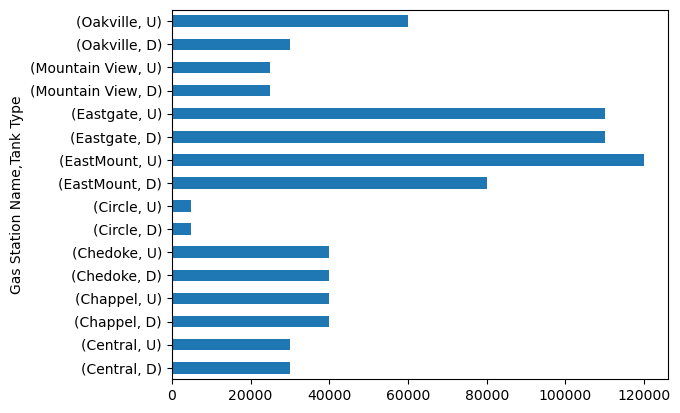

In [51]:
# station_capacity.pivot(columns=['Gas Station Name', 'Tank Type'], values='Tank Capacity')
fig, ax = plt.subplots()
df_cap_sum = station_capacity.groupby(by=['Gas Station Name', 'Tank Type'])['Tank Capacity'].sum()
df_cap_sum.plot(kind='barh', ax=ax)
display(df_cap_sum)

In [52]:
df_cap_sum.head(16)

Gas Station Name  Tank Type
Central           D             30000
                  U             30000
Chappel           D             40000
                  U             40000
Chedoke           D             40000
                  U             40000
Circle            D              5000
                  U              5000
EastMount         D             80000
                  U            120000
Eastgate          D            110000
                  U            110000
Mountain View     D             25000
                  U             25000
Oakville          D             30000
                  U             60000
Name: Tank Capacity, dtype: int64

## 2) Monthly and daily utilization per station per fuel type

In [53]:
# merging station_by_month  (inventory) with cap_sum (sum of capacity)
monthly_utilization = df_station_by_month.merge(right = df_cap_sum.reset_index(),
                          how = 'inner',
                          left_on = ['Gas Station Name', 'Tank Type'], 
                          right_on = ['Gas Station Name', 'Tank Type'],
                          validate = 'm:1'
                          )

# same for day
daily_utilization = df_station_by_day.merge(right = df_cap_sum.reset_index(),
                          how = 'inner',
                          left_on = ['Gas Station Name', 'Tank Type'], 
                          right_on = ['Gas Station Name', 'Tank Type'],
                          validate = 'm:1'
                          )


In [54]:
monthly_utilization.head(5)

Gas Station Name Tank Type Time stamp    Fuel Level  Tank Capacity
0          Central         D    2017-01  18402.691601          30000
1          Central         D    2017-02  21972.734998          30000
2          Central         D    2017-03  19314.740728          30000
3          Central         D    2017-04  18778.300493          30000
4          Central         D    2017-05  20267.904762          30000

In [55]:
# creating new column for utilization for both
monthly_utilization['Monthly Util'] = monthly_utilization['Fuel Level'].div(monthly_utilization['Tank Capacity'])
daily_utilization['Daily Util'] = daily_utilization['Fuel Level'].div(daily_utilization['Tank Capacity'])


In [56]:
daily_utilization.head()

Gas Station Name Tank Type  Time stamp    Fuel Level  Tank Capacity  \
0          Central         D  2017-01-01  14448.416667          30000   
1          Central         D  2017-01-02  13794.794872          30000   
2          Central         D  2017-01-03  12720.175000          30000   
3          Central         D  2017-01-04  11863.583333          30000   
4          Central         D  2017-01-05  10720.916667          30000   

   Daily Util  
0    0.481614  
1    0.459826  
2    0.424006  
3    0.395453  
4    0.357364

In [57]:
# get the average/min/max utilization per station per fuel type
min_max_avg_daily_util = daily_utilization.groupby(by = ['Gas Station Name','Tank Type']).agg({'Daily Util':['min','mean','max']})
min_max_avg_daily_util

Daily Util                    
                                  min      mean       max
Gas Station Name Tank Type                               
Central          D           0.325372  0.662599  0.893791
                 U           0.322457  0.689387  0.938365
Chappel          D           0.335125  0.680891  0.876467
                 U           0.145369  0.622676  0.875214
Chedoke          D           0.356499  0.699820  0.902083
                 U           0.507246  0.719272  0.890592
Circle           D           0.336842  0.702814  0.905206
                 U           0.296800  0.607398  0.919091
EastMount        D           0.243683  0.355836  0.418870
                 U           0.127418  0.202346  0.267044
Eastgate         D           0.308793  0.403784  0.464971
                 U           0.313001  0.404113  0.456038
Mountain View    D           0.355400  0.678713  0.902773
                 U           0.227418  0.619694  0.857626
Oakville         D           0.504329  0.749252  0.956965
                 U           0.198083  0.357828  0.465911

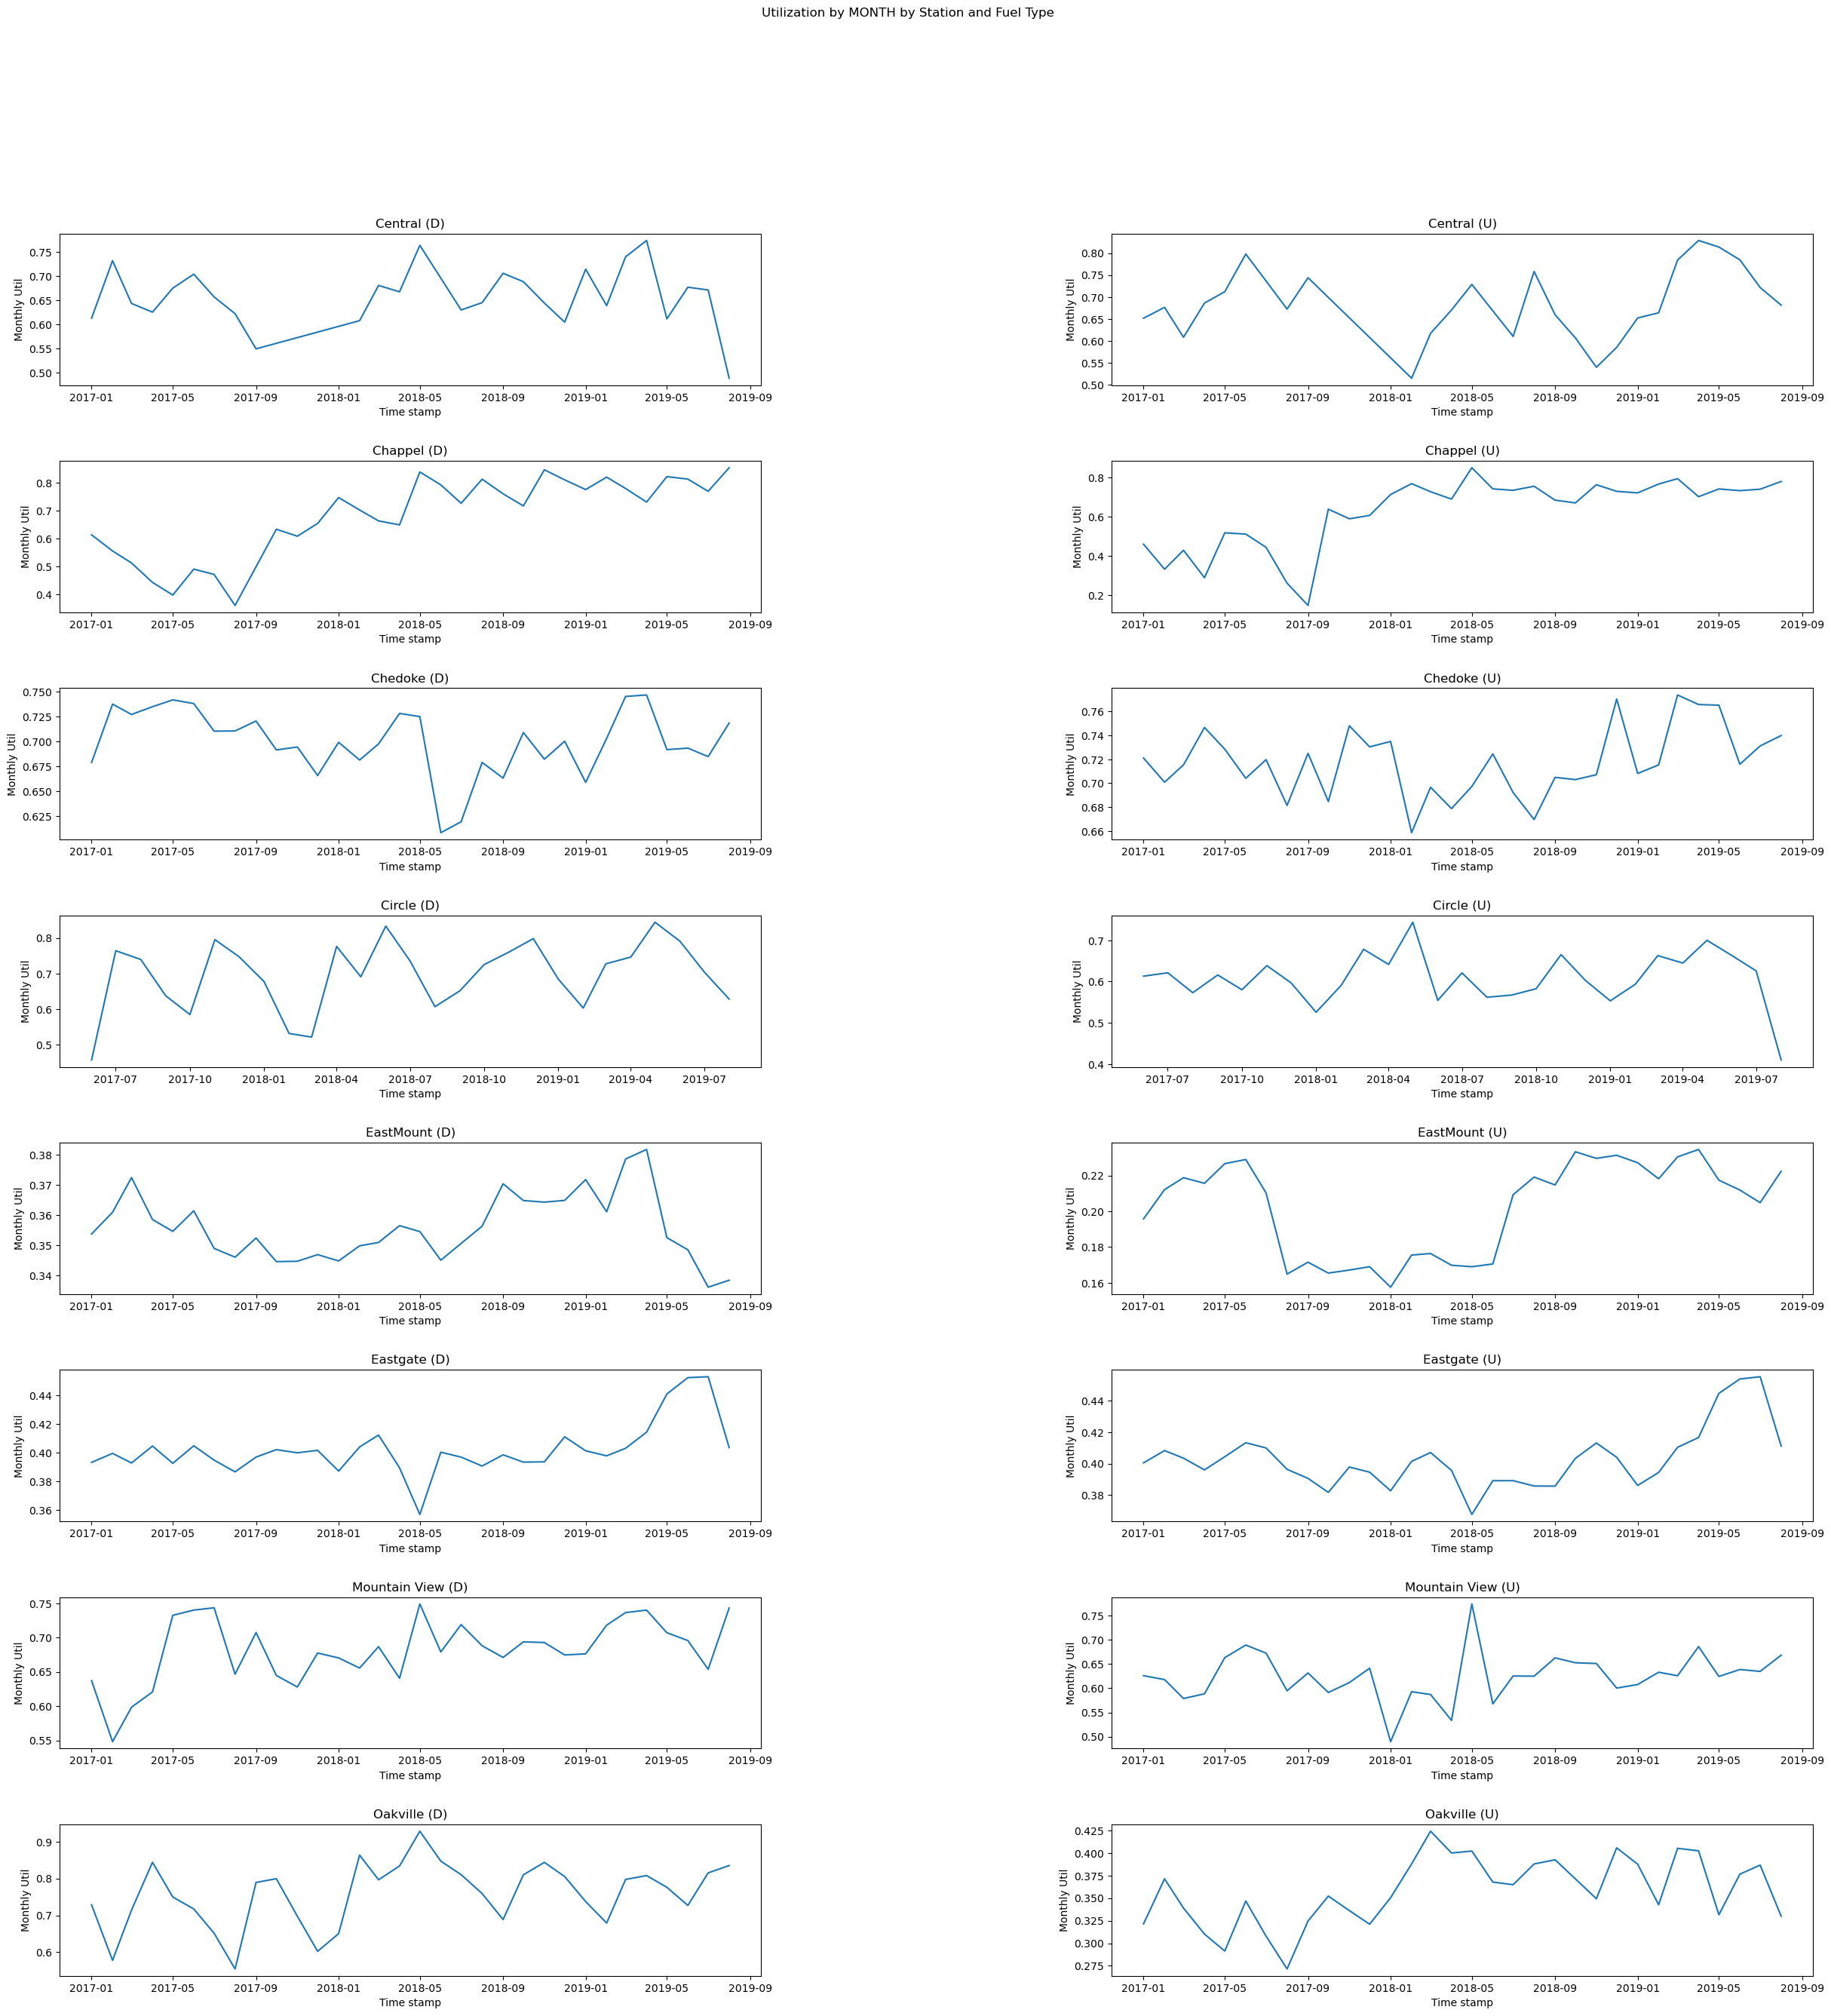

In [58]:
# monthly plot
plot_per_station_per_fuel(df = monthly_utilization,
                          xname = "Time stamp",
                          yname = "Monthly Util",
                          desc = "Utilization by MONTH")

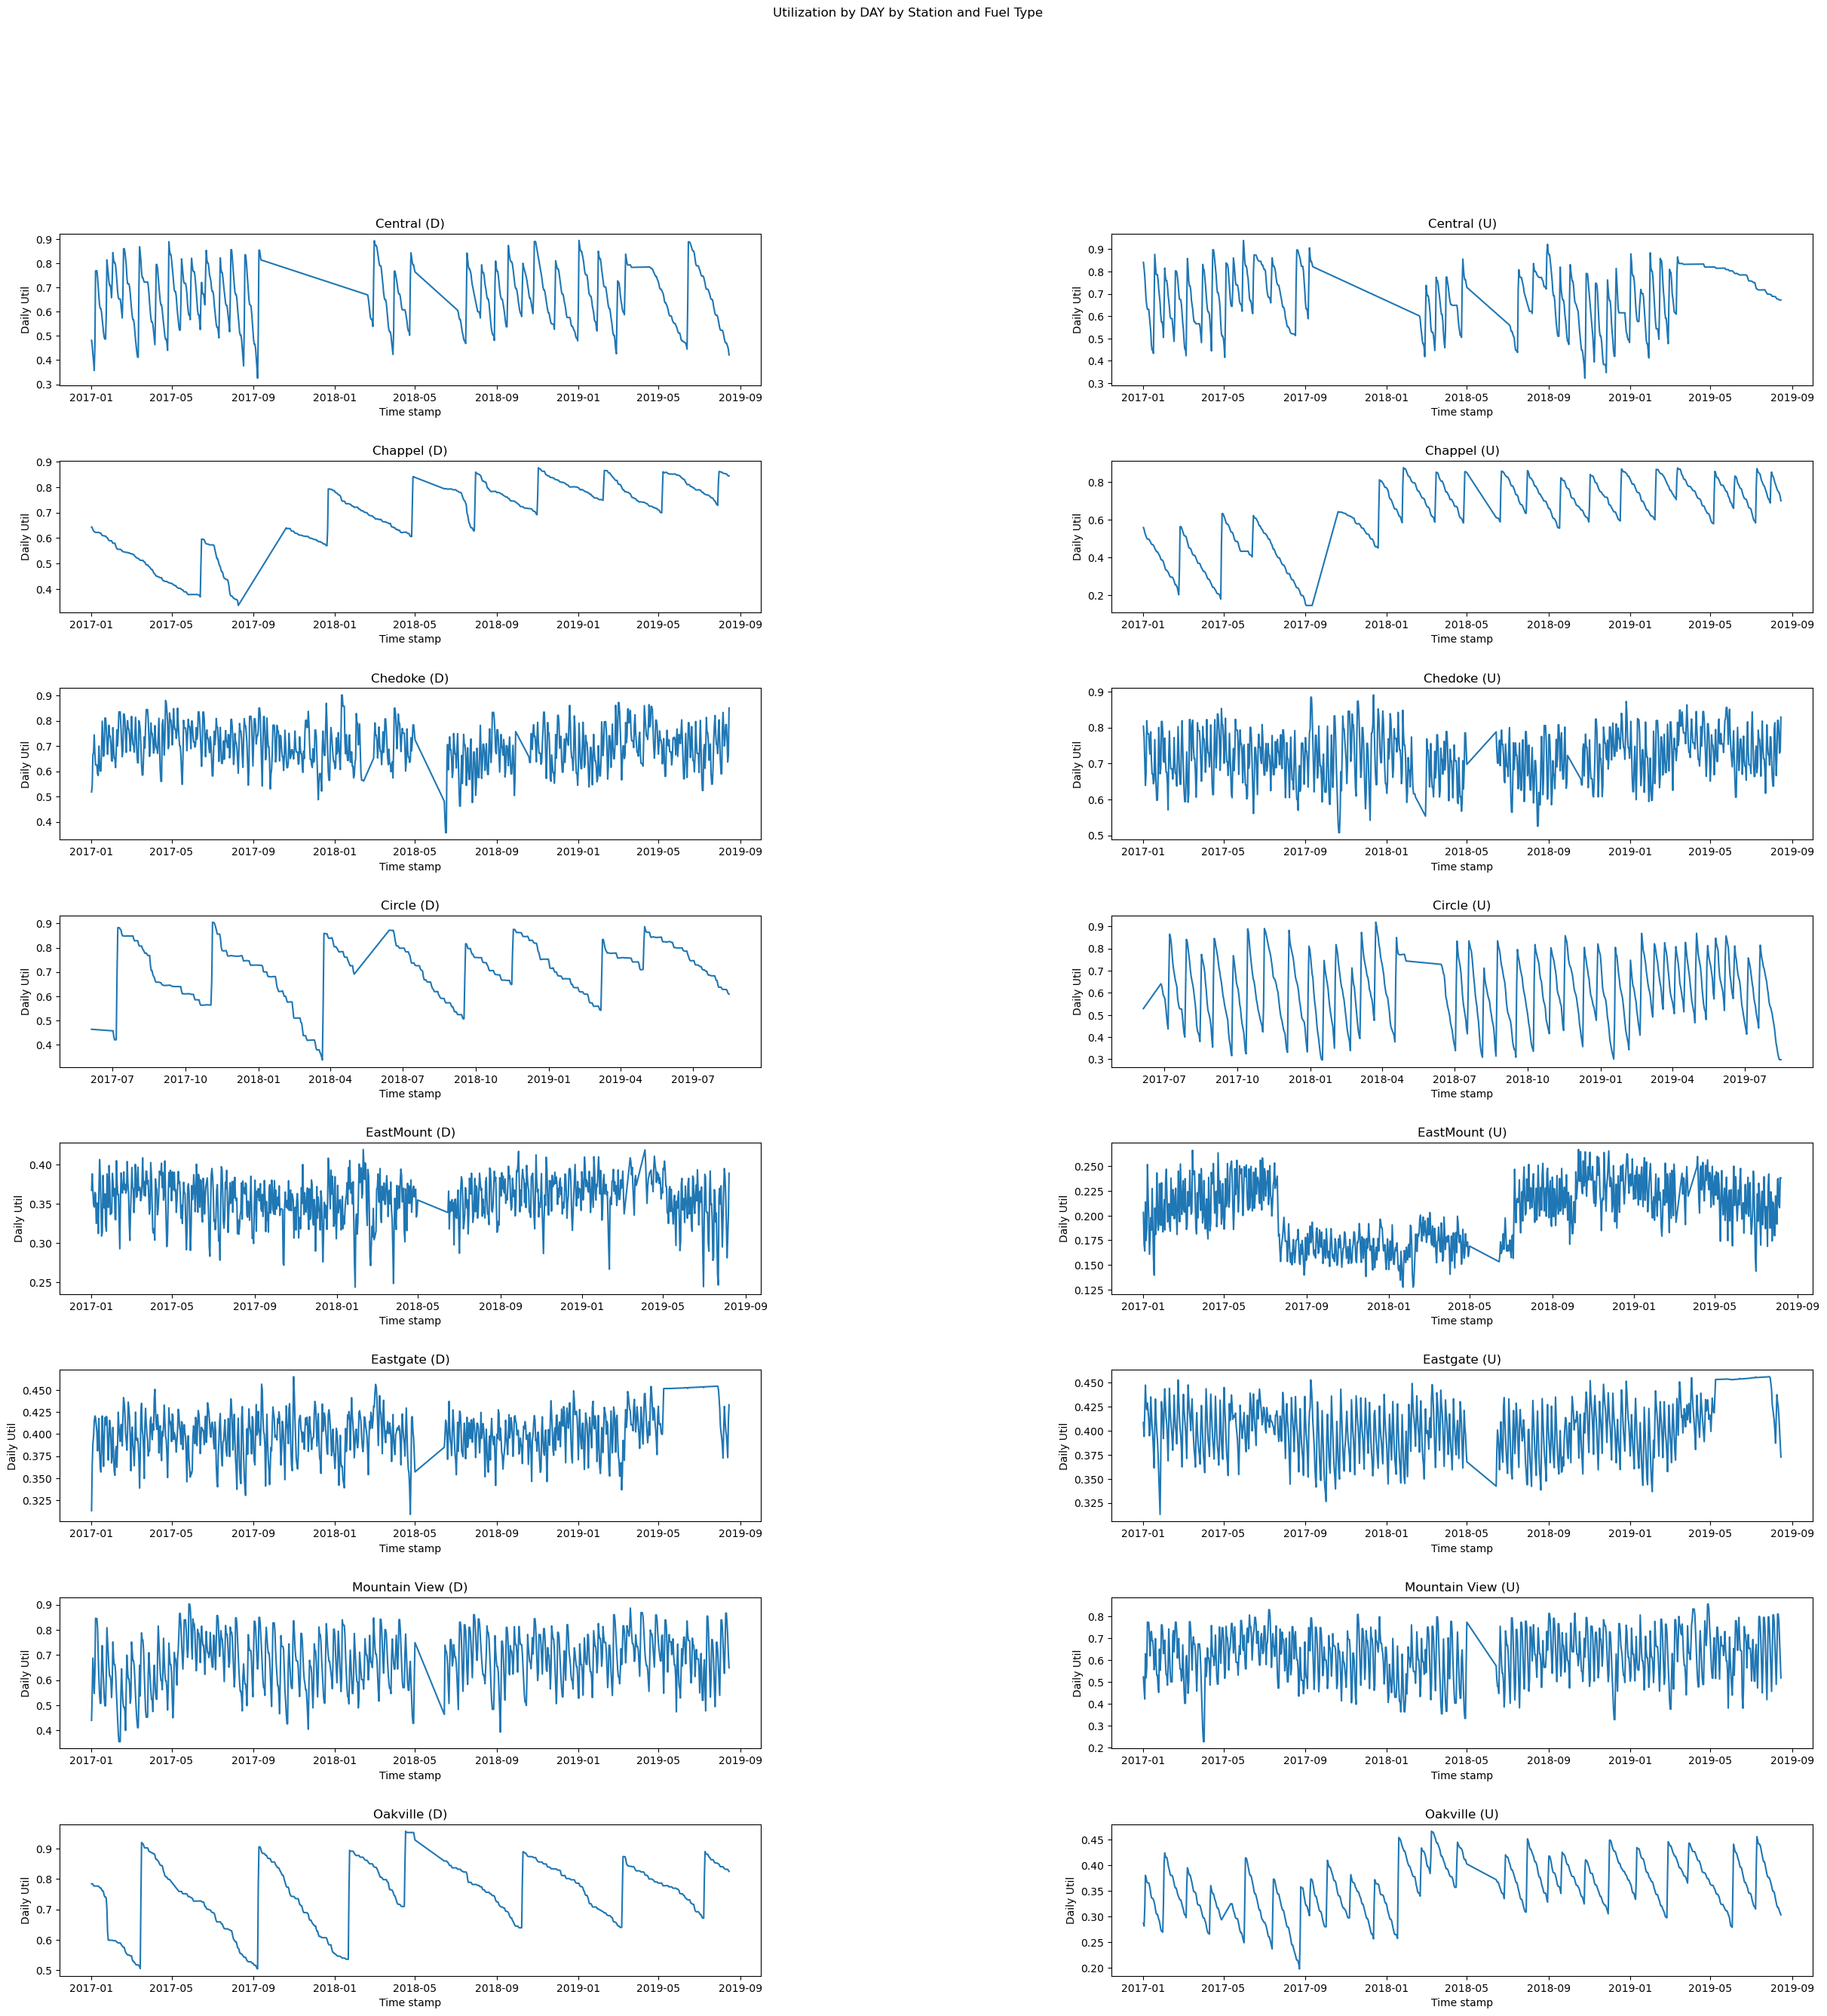

In [59]:
# daily plot
plot_per_station_per_fuel(df = daily_utilization,
                          xname = "Time stamp",
                          yname = "Daily Util",
                          desc = "Utilization by DAY")


## 3) Capacity and utilization analysis

In [60]:
demand_info = pd.merge(demand_info, df_cap_sum,  how='left', left_on=['Station name','Fuel Type'], right_on = ['Gas Station Name','Tank Type'],validate = '1:1')
demand_info = pd.merge(demand_info, min_max_avg_daily_util,  how='left', left_on=['Station name','Fuel Type'], right_on = ['Gas Station Name','Tank Type'],validate = '1:1')

In [61]:
table = table.merge(locations,  how = 'outer', left_on = 'Tank Location', right_on = 'Gas Station Location', validate='m:1')

In [62]:
table = table[['Tank Location','Tank Type','Tank Number']]

In [63]:
pd.DataFrame(table)

Tank Location Tank Type  Tank Number
0               1         D            2
1               1         U            3
2               2         D            2
3               2         U            2
4               3         D            1
5               3         U            1
6               4         D            1
7               4         U            1
8               5         D            1
9               5         U            1
10              6         D            1
11              6         U            2
12              7         D            1
13              7         U            1
14              8         D            1
15              8         U            1

In [64]:
demand_info = pd.concat([demand_info,table],axis=1)
demand_info.drop(columns = ['Tank Location','Tank Type'], inplace = True)

In [65]:
demand_info['Tank Number'] = demand_info['Tank Number'].astype(float)
demand_info['Capacity Per Tank'] = demand_info['Tank Capacity'].div(demand_info['Tank Number'])

In [66]:
demand_info

Station name Fuel Type  Average Daily Demand  \
0         Central         D            312.740822   
1         Central         U            344.002775   
2         Chappel         D             69.060393   
3         Chappel         U            218.725231   
4         Chedoke         D            989.797464   
5         Chedoke         U            914.394637   
6          Circle         D             12.740187   
7          Circle         U             87.013061   
8       EastMount         D            860.686963   
9       EastMount         U           1021.476263   
10       Eastgate         D            831.011839   
11       Eastgate         U            895.676891   
12  Mountain View         D            679.071661   
13  Mountain View         U            865.910524   
14       Oakville         D             65.610046   
15       Oakville         U            190.544202   

    Daily Demand Standard Deviation  Safety Stock          ROP     Price  \
0                        444.093572   1771.303388  2709.525854  1.163587   
1                        718.034934   1948.365031  2980.373356  1.079401   
2                        133.874335    391.144679   598.325859  1.343651   
3                        379.862243   1238.817306  1894.992999  1.184023   
4                       1313.083049   5606.020955  8575.413347  1.291947   
5                       1034.281108   5178.953959  7922.137870  1.146347   
6                         31.923243     72.157948   110.378509  1.386362   
7                         58.905972    492.825110   753.864294  1.203315   
8                       1113.486419   4874.764107  7456.824997  1.289640   
9                       1217.948243   5785.443533  8849.872324  1.172297   
10                      1029.554627   4706.689956  7199.725472  1.226490   
11                       612.377549   5072.940274  7759.970946  1.125573   
12                       704.549209   3846.130242  5883.345224  1.312946   
13                       906.004050   4904.349345  7502.080918  1.150962   
14                       157.021773    371.602582   568.432720  1.311740   
15                       138.372139   1079.205421  1650.838027  1.127866   

    Optimal Order Quantity  Tank Capacity  (Daily Util, min)  \
0             45833.274773          30000           0.325372   
1             49908.840142          30000           0.322457   
2             20042.842611          40000           0.335125   
3             37997.706558          40000           0.145369   
4             77381.799590          40000           0.356499   
5             78958.110689          40000           0.507246   
6              8474.958755           5000           0.336842   
7             23773.359522           5000           0.296800   
8             72223.147212          80000           0.243683   
9             82524.572063         120000           0.127418   
10            72771.198489         110000           0.308793   
11            78863.660336         110000           0.313001   
12            63580.264121          25000           0.355400   
13            76682.095728          25000           0.227418   
14            19771.941140          30000           0.504329   
15            36337.678487          60000           0.198083   

    (Daily Util, mean)  (Daily Util, max)  Tank Number  Capacity Per Tank  
0             0.662599           0.893791          2.0            15000.0  
1             0.689387           0.938365          3.0            10000.0  
2             0.680891           0.876467          2.0            20000.0  
3             0.622676           0.875214          2.0            20000.0  
4             0.699820           0.902083          1.0            40000.0  
5             0.719272           0.890592          1.0            40000.0  
6             0.702814           0.905206          1.0             5000.0  
7             0.607398           0.919091          1.0             5000.0  
8             0.355836           0.41

# 5. Purchasing Strategy Optimization

## 0) Get inflation rates by month
`https://www.rateinflation.com/inflation-rate/canada-inflation-rate/`

In [67]:
inflation_rates = {
    2016: [2.0, 1.4, 1.3, 1.7, 1.5, 1.5, 1.3, 1.1, 1.3, 1.5, 1.2, 1.5],
    2017: [2.1, 2.0, 1.6, 1.6, 1.3, 1.0, 1.2, 1.4, 1.6, 1.4, 2.1, 1.9],
    2018: [1.7, 2.2, 2.3, 2.2, 2.2, 2.5, 3.0, 2.8, 2.2, 2.4, 1.7, 2.0],
    2019: [1.4, 1.5, 1.9, 2.0, 2.4, 2.0, 2.0, 1.9, 1.9, 1.9, 2.2, 2.2],
    2020: [2.4, 2.2, 0.9,	-0.2,	-0.4,	0.7, 0.1, 0.1, 0.5, 0.7, 1.0, 0.7],
    2021: [1.0, 1.1, 2.2, 3.4, 3.6, 3.1, 3.7, 4.1, 4.4, 4.7, 4.7, 4.8],
}

In [68]:
# dataframe for monthly inflation rates in canada, in percentage
df_inflation_rates = pd.DataFrame(inflation_rates, index=list(range(1, 13)))
df_inflation_rates

2016  2017  2018  2019  2020  2021
1    2.0   2.1   1.7   1.4   2.4   1.0
2    1.4   2.0   2.2   1.5   2.2   1.1
3    1.3   1.6   2.3   1.9   0.9   2.2
4    1.7   1.6   2.2   2.0  -0.2   3.4
5    1.5   1.3   2.2   2.4  -0.4   3.6
6    1.5   1.0   2.5   2.0   0.7   3.1
7    1.3   1.2   3.0   2.0   0.1   3.7
8    1.1   1.4   2.8   1.9   0.1   4.1
9    1.3   1.6   2.2   1.9   0.5   4.4
10   1.5   1.4   2.4   1.9   0.7   4.7
11   1.2   2.1   1.7   2.2   1.0   4.7
12   1.5   1.9   2.0   2.2   0.7   4.8

In [69]:
invoices.head()

Invoice Date  Invoice ID  Invoice Gas Station Location  Gross Purchase Cost  \
0     1/2/2017     10000.0                             1             7570.820   
1     1/2/2017     10001.0                             1            12491.853   
2     1/2/2017     10002.0                             1                  NaN   
3     1/2/2017     10002.0                             2            17034.345   
4     1/2/2017         NaN                             2                  NaN   

   Amount Purchased Fuel Type  
0          6609.600         G  
1          9338.736         D  
2               NaN       NaN  
3         13377.824         D  
4               NaN       NaN

In [70]:
# choose inflation rate matching to our data's period
print(f"The beginning time in dataset is {df_filtered_amounts['Invoice Date'].min()}.")
print(f"The ending time in dataset is {df_filtered_amounts['Invoice Date'].max()}.")

The beginning time in dataset is 2017-01-02 00:00:00.
The ending time in dataset is 2019-08-15 00:00:00.


In [71]:
# Therefore, we use inflation rate between Jan 2017 and Auguest 2019 to calculate FV factor.
inflation_rates_2 = np.array([2.1, 2.0, 1.6, 1.6, 1.3, 1.0, 1.2, 1.4, 1.6, 1.4, 2.1, 1.9, 1.7, 2.2, 2.3, 2.2, 2.2, 2.5, 3.0, 2.8, 2.2, 2.4, 1.7, 2.0,1.4, 1.5, 1.9, 2.0, 2.4, 2.0, 2.0])
discount_rate = 1+ inflation_rates_2*0.01

temp = 1
reverse_list_fv_factor = []
for i in discount_rate[::-1]:
    temp *= i
    reverse_list_fv_factor.append(temp)
print(reverse_list_fv_factor)

[1.02, 1.0404, 1.0653696, 1.086676992, 1.1073238548479998, 1.1239337126707196, 1.1396687846481097, 1.1624621603410719, 1.1822240170668699, 1.2105973934764747, 1.2372305361329572, 1.27187299114468, 1.3100291808790205, 1.3427799104009959, 1.3723210684298177, 1.4025121319352738, 1.434769910969785, 1.46633484901112, 1.491262541444309, 1.5195965297317509, 1.5515080568561175, 1.5732291696521032, 1.598400836366537, 1.6207784480756684, 1.6402277894525765, 1.6566300673471024, 1.6781662582226144, 1.7050169183541763, 1.7322971890478431, 1.7669431328288001, 1.8040489386182048]


In [72]:
list_fv_factor = reverse_list_fv_factor[::-1]
df_fv_factor = pd.DataFrame(list_fv_factor,index = range(1,32)).reset_index().rename(columns = {0:'FV Factor','index' : 'Month Index'})
df_fv_factor

Month Index  FV Factor
0             1   1.804049
1             2   1.766943
2             3   1.732297
3             4   1.705017
4             5   1.678166
5             6   1.656630
6             7   1.640228
7             8   1.620778
8             9   1.598401
9            10   1.573229
10           11   1.551508
11           12   1.519597
12           13   1.491263
13           14   1.466335
14           15   1.434770
15           16   1.402512
16           17   1.372321
17           18   1.342780
18           19   1.310029
19           20   1.271873
20           21   1.237231
21           22   1.210597
22           23   1.182224
23           24   1.162462
24           25   1.139669
25           26   1.123934
26           27   1.107324
27           28   1.086677
28           29   1.065370
29           30   1.040400
30           31   1.020000

In [73]:
# creating column 'Month Index' to match fv factor and potential savings in certain month.
df_filtered_amounts['Year'] = df_filtered_amounts['Invoice Date'].dt.year
df_filtered_amounts['Month'] = df_filtered_amounts['Invoice Date'].dt.month
df_filtered_amounts['Month Index'] = df_filtered_amounts['Month']+(df_filtered_amounts['Year']-2017)*12

## 1) Potential Savings

### a) potential savings on purchasing strategy for tiered price

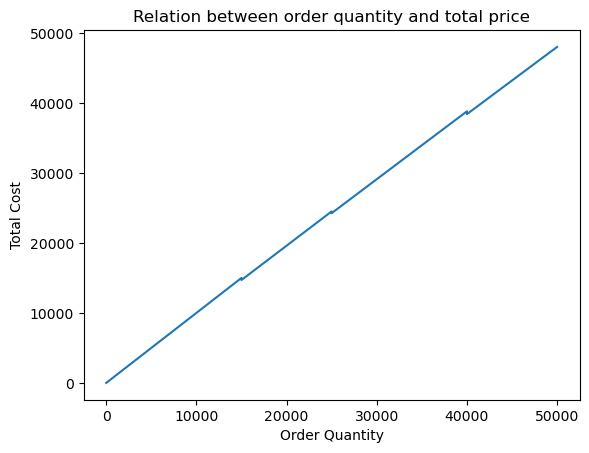

In [74]:
# graph of tiered price when full price of one liter is $1.
x = np.linspace(0,50000,50000)
interval0 = np.array([1 if (i<15000) else 0 for i in x])
interval1 = np.array([0.98 if (i>=15000 and i<25000) else 0 for i in x])
interval2 = np.array([0.97 if (i>=25000 and i<40000) else 0 for i in x])
interval3 = np.array([0.96 if (i>=40000) else 0 for i in x])

y = x*(interval0 + interval1 + interval2 + interval3)

plt.plot(x,y)
plt.xlabel('Order Quantity')
plt.ylabel('Total Cost')
plt.title('Relation between order quantity and total price')
plt.show()

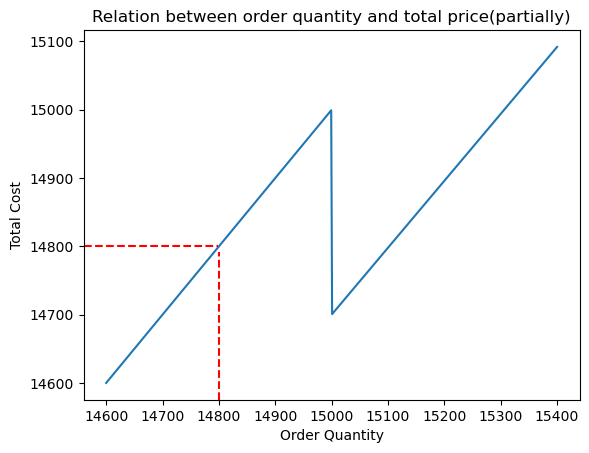

In [75]:
# zoom in to illustrate potential saving opportunity, assume full price of 1 liter is $1
x = np.linspace(14600,15400,500)
interval0 = np.array([1 if (i<15000) else 0 for i in x])
interval1 = np.array([0.98 if (i>=15000 and i<25000) else 0 for i in x])

y = x*(interval0 + interval1)

plt.plot(x,y)
plt.axhline(y =14800,xmax = 0.27, ls="--",c="red")
plt.axvline(x =14800,ymax = 0.4, ls="--",c="red")
plt.xlabel('Order Quantity')
plt.ylabel('Total Cost')
plt.title('Relation between order quantity and total price(partially)')
plt.show()

# Buying 14700 liters cost the same as 15000. If we buy 14800 and cost $14800, it's not a good deal. 
# We could get more(15000 liters) at a lower price($14700). The difference $100 is potential saving.

In [76]:
def check_discount(num):
  ''' Pass in order amount, returns discount per liter in cents '''
  if num < 15_000: return 0
  if num >= 15_000 and num < 25_000: return 2
  if num >= 25_000 and num < 40_000: return 3
  if num >= 40_000: return 4

def check_upper_bound (num): 
  ''' Pass in purchase amount, return upperbound of discount bracket ''' 
  if num < 15_000: return 15000
  if num >= 15_000 and num < 25_000: return 25_000
  if num >= 25_000 and num < 40_000: return 40_000
  if num >= 40_000: return float(inf)


In [77]:
# factors needed to calculate new cost
df_filtered_amounts['Upper Bound'] = df_filtered_amounts['Amount Purchased'].apply(check_upper_bound)
df_filtered_amounts['Current Discount Per Liter'] = df_filtered_amounts['Amount Purchased'].apply(check_discount)
df_filtered_amounts['New Discount Per Liter'] = df_filtered_amounts['Upper Bound'].apply(check_discount)



In [78]:
# checking if there's any amount purchased for more than 40_000, there is none 
df_filtered_amounts['Amount Purchased'].max()

33826.56

In [79]:
# New cost is the cost if we buy 'Upper Bound' amount of fuel
df_filtered_amounts['New Cost'] = df_filtered_amounts['Upper Bound'] * (df_filtered_amounts['Gross Purchase Cost'] / df_filtered_amounts['Amount Purchased'] + \
                                     df_filtered_amounts['Current Discount Per Liter']*0.01 - df_filtered_amounts['New Discount Per Liter']*0.01)


In [80]:
# potential savings with this strategy of purchasing the lowest of the next bracket
df_filtered_amounts['Potential Saving'] = df_filtered_amounts['Gross Purchase Cost'] - df_filtered_amounts['New Cost']


In [81]:
savings = df_filtered_amounts[df_filtered_amounts['Potential Saving'] > 0]['Potential Saving'].sum() / df_filtered_amounts['Gross Purchase Cost'].sum()

In [82]:
# purchases where we are saving money by using new strategy
print(f"total purchase amounts = {df_filtered_amounts['Gross Purchase Cost'].sum():,.2f}")
print(f"amount saved = ${df_filtered_amounts.loc[df_filtered_amounts['Potential Saving'] > 0, 'Potential Saving'].sum():,.2f}")
print(f'We saved ${savings:.5%}!')


total purchase amounts = 33,298,726.25
amount saved = $2,769.86
We saved $0.00832%!


In [83]:
# Now let's take time value of money into consideration.
df_filtered_amounts = df_filtered_amounts.merge(df_fv_factor, on = 'Month Index', how = 'left', validate = 'm:1').drop_duplicates()

In [84]:
df_filtered_amounts_fv_calculation = df_filtered_amounts[df_filtered_amounts['Potential Saving']>0]
df_filtered_amounts_fv_calculation['FV of potential saving'] = df_filtered_amounts_fv_calculation['FV Factor'] * df_filtered_amounts_fv_calculation['Potential Saving']
df_filtered_amounts_fv_calculation['FV of potential saving'].sum()

3864.6871075880986

In [91]:
df_filtered_amounts['money_saved'] = df_filtered_amounts['Current Discount Per Liter'] * df_filtered_amounts['Amount Purchased'] * 0.01
df_filtered_amounts['FV of money_saved'] = df_filtered_amounts['FV Factor'] * df_filtered_amounts['money_saved']
df_filtered_amounts['FV of money_saved'].sum()

298099.20771977847

In [108]:
df_filtered_amounts[df_filtered_amounts['money_saved'] > 0].head(10)

Gas Station Name Tank Type Invoice Date  Amount Purchased  \
4         EastMount         U   2017-01-03         26704.960   
10        EastMount         U   2017-01-06         26406.496   
16        EastMount         U   2017-01-11         26347.472   
20        EastMount         U   2017-01-13         26014.768   
25        EastMount         U   2017-01-17         26008.640   
28        EastMount         U   2017-01-20         25987.216   
36        EastMount         U   2017-01-24         24478.720   
42        EastMount         U   2017-01-27         26014.768   
45        EastMount         U   2017-01-31         26002.512   
49        EastMount         U   2017-02-03         26011.696   

    Gross Purchase Cost     Price  Year  Month  Month Index  Upper Bound  \
4           32175.98500  1.204869  2017      1            1        40000   
10          31816.37105  1.204869  2017      1            1        40000   
16          32175.98500  1.221217  2017      1            1        40000   
20          32183.55582  1.237126  2017      1            1        40000   
25          32175.98500  1.237127  2017      1            1        40000   
28          32149.48713  1.237127  2017      1            1        40000   
36          30283.28000  1.237127  2017      1            1        25000   
42          32183.55582  1.237126  2017      1            1        40000   
45          32168.41418  1.237127  2017      1            1        40000   
49          32179.77041  1.237127  2017      2            2        40000   

    Current Discount Per Liter  New Discount Per Liter      New Cost  \
4                            3                       4  47794.769811   
10                           3                       4  47794.763970   
16                           3                       4  48448.686508   
20                           3                       4  49085.055289   
25                           3                       4  49085.071115   
28                           3                       4  49085.080864   
36                           2                       3  30678.169447   
42                           3                       4  49085.055289   
45                           3                       4  49085.086949   
49                           3                       4  49085.078420   

    Potential Saving  FV Factor  money_saved  FV of money_saved  
4      -15618.784811   1.804049    801.14880        1445.311642  
10     -15978.392920   1.804049    792.19488        1429.158332  
16     -16272.701508   1.804049    790.42416        1425.963867  
20     -16901.499469   1.804049    780.44304        1407.957438  
25     -16909.086115   1.804049    780.25920        1407.625782  
28     -16935.593734   1.804049    779.61648        1406.466283  
36       -394.889447   1.804049    489.57440         883.216177  
42     -16901.499469   1.804049    780.44304        1407.957438  
45     -16916.672769   1.804049    780.07536        1407.294125  
49     -16905.308010   1.766943    780.35088        1378.835629

## 2) Best day to order fuel


In [87]:
# calcualte cost per liter for each invoice
purchase_per_location['Cost Per Liter'] = purchase_per_location['Gross Purchase Cost'].div(purchase_per_location['Amount Purchased'])



In [88]:
# we checked, there is no purchases made on Sunday (Saturday has lowest unit cost. )
grouped_data = purchase_per_location[['Invoice Date', 'Gross Purchase Cost', 'Amount Purchased', 'Cost Per Liter']]\
          .groupby(by=purchase_per_location['Invoice Date'].dt.day_name())['Cost Per Liter']

display(grouped_data.mean().sort_values())
display(grouped_data.min().sort_values())
display(grouped_data.max().sort_values())



Invoice Date
Saturday     1.072114
Monday       1.184915
Thursday     1.190079
Wednesday    1.195567
Friday       1.217580
Tuesday      1.256319
Name: Cost Per Liter, dtype: float64

Invoice Date
Friday       0.876578
Thursday     0.888210
Saturday     0.907685
Wednesday    0.907688
Monday       0.915765
Tuesday      0.922513
Name: Cost Per Liter, dtype: float64

Invoice Date
Saturday     1.352937
Tuesday      2.723214
Thursday     2.811505
Friday       2.864610
Monday       3.226788
Wednesday    3.239158
Name: Cost Per Liter, dtype: float64